# Notebook: Estudo da variação da janela (win) e norma (norm) para sinais come sem ruído

Descrição:

Neste notebook apresenta-se os resultados do estudo da variação de win e norm para sinais com e sem ruído. Sinais simulados são utilizados para gerar espectrogramas (Seção 1.0) que são observados juntamente com métricas quantitativas que auxiliam na caracterização do espectrograma com relação a variação do hop.

Como resultados principais (Seção 2.0) apresenta-se considerações visuais da variação win-norm, caracteriza-se a largura dos picos em função de win-norm, observa-se o perfil dos picos e como eles mudam considerando os parâmetros em questão, analisa-se o comprimento e listras dos picos em função de win-norm.

Além disso, traz-se alguns resultados de variações estatísticas do espectrograma em função de win-norm (Seção 3.0), considerando a imagem globalmente e considerando apenas a região de resíduos/ruído.

## 0.0 Definições:

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.signal.windows import hann, boxcar, flattop
import json
from matplotlib.gridspec import GridSpec

In [2]:
import pandas as pd
from IPython.display import display, HTML

In [3]:
import utils
import functions_for_param_study as funcstud

In [4]:
def get_result_table(dict_multinfo,norm_names,window_names):
    """
    Define DF to print results obtained for multiple norms and windows.
    Inputs:
    dict_multinfo: dict with keys 'NAA', 'GABA' and 'Glx', for each key there is a list of dicts with the information for each window within each norm
                    example: dict_multinfo['NAA'][0] = {'mean': [a,b,c,d],
                                                        'std': [1,2,3,4]} -> mean information obtained four norm of idx 0 and with each of the four 
                                                                            windows consired, accompanied by their respective std of the measured mean value
    norm_names: list with the names of each norm (in the same order they appear in dict_multinfo['NAA'])
    window_names: list with the names of each window (in the same order they appear in dict_multinfo['NAA'][0])
    """
    struct = {}
    for ele in ['NAA','GABA','Glx']:
        for j in range(len(window_names)):
            struct[(ele, window_names[j])] = []
            for i in range(len(norm_names)):
                struct[(ele, window_names[j])].append("{:.2e}".format(dict_multinfo[ele][i]['mean'][j]) + '±' + "{:.2e}".format(dict_multinfo[ele][i]['std'][j]))
               
    df = pd.DataFrame(struct, index=norm_names)
    display(HTML(df.to_html()))

## 1.0 Aquisição dos sinais simulados, geração dos espectrogramas e carregamento das métricas quantitativas:

In [5]:
qntty = 100
test_not_save = True

In [6]:
#Import data obtained on EditedMRS_Reconstruction_Challenge github -- Ground-truths
with h5py.File('../sample_data.h5') as hf:
  print(hf.keys())
  gt_fids = hf["ground_truth_fids"][()][:qntty]
  ppm = hf["ppm"][()][:qntty]
  t = hf["t"][()][:qntty]
  print(gt_fids.shape)
  print(ppm.shape)
  print(t.shape)

<KeysViewHDF5 ['ground_truth_fids', 'ppm', 't']>
(100, 2048, 2)
(100, 2048)
(100, 2048)


In [7]:
dwelltime = t[0,1]-t[0,0]
bandwidth = 1/dwelltime
N = gt_fids.shape[1]

#gts
spectra_gt_fids = np.fft.fftshift(np.fft.ifft(gt_fids,n=N,axis = 1), axes = 1)
spectra_gt_diff = spectra_gt_fids[:,:,1] - spectra_gt_fids[:,:,0]
freq = np.flip(np.fft.fftshift(np.fft.fftfreq(N, d = dwelltime)))

#to get ppm axis
idx_min = np.real(spectra_gt_diff[0,:]).argmin()
idx_max = np.real(spectra_gt_diff[0,:]).argmax()
#p = a*f + b
a = (ppm[0,idx_max] - ppm[0,idx_min])/(freq[idx_max]-freq[idx_min])
b = ppm[0,idx_max] - a*freq[idx_max]
#ppm_aux = b + freq*a

In [8]:
corrupted_fids = utils.create_corrupted_fids(gt=gt_fids,t=t,std_base=6,std_var=2,ntransients=160)

In [9]:
mfft_ = 512
window_ = [hann(mfft_,sym=True),boxcar(mfft_,sym=True),flattop(mfft_,sym=True)]
win_name =['hann','rect','flat']
hop_ = 8
norm_ = ['abs','m1p1','minmax','zscore']
spgram_wn_gt = {}
spgram_wn_ns = {}
for i in range(len(norm_)):
    spgram_wn_gt['norm_'+norm_[i]] = {}
    spgram_wn_ns['norm_'+norm_[i]] = {}
for i in range(len(norm_)):
    for j in range(len(window_)):
        spgram_gt, freq_spect, ppm_spect, t_spect = utils.get_normalized_spectrogram(fids=gt_fids[:,:,1]-gt_fids[:,:,0],bandwidth=bandwidth,window=window_[j],mfft=mfft_,hop=hop_,norm=norm_[i],correct_time=True,a=a,b=b)
        spgram_wn_gt['norm_'+norm_[i]]['window_'+win_name[j]] = [spgram_gt, freq_spect, ppm_spect, t_spect]
        spgram_ns, freq_spect, ppm_spect, t_spect = utils.get_normalized_spectrogram(fids=np.mean(corrupted_fids[:,:,1,:]-corrupted_fids[:,:,0,:],axis=2),bandwidth=bandwidth,window=window_[j],mfft=mfft_,hop=hop_,norm=norm_[i],correct_time=True,a=a,b=b)
        spgram_wn_ns['norm_'+norm_[i]]['window_'+win_name[j]] = [spgram_ns, freq_spect, ppm_spect, t_spect]

Algumas colunas e linhas de interesse na análise dos espectrogramas:

In [10]:
idx_time_0d05 = [] 
idx_time_0d4 = []
idx_time_0d6 = [] 
idx_freq_0ppm = [] 
idx_freq_1ppm = [] 
idx_freq_4ppm = [] 
idx_freq_8ppm = [] 
idx_freq_6ppm = [] 
idx_freq_8d5ppm = []
idx_freq_NAA = [] 
idx_freq_GABA = []
idx_freq_Glx = []
for i in range(len(norm_)):
    list_of_t_spects = []
    list_of_ppm_spects = []
    for j in range(len(window_)):
        list_of_t_spects.append(spgram_wn_gt['norm_'+norm_[i]]['window_'+win_name[j]][-1])
        list_of_ppm_spects.append(spgram_wn_gt['norm_'+norm_[i]]['window_'+win_name[j]][2])
    idx_time_0d05.append(utils.give_idx_time_point_for_different_time_arrays(list_time_arrays=list_of_t_spects,time_point=0.05))
    idx_time_0d4.append(utils.give_idx_time_point_for_different_time_arrays(list_time_arrays=list_of_t_spects,time_point=0.4))
    idx_time_0d6.append(utils.give_idx_time_point_for_different_time_arrays(list_time_arrays=list_of_t_spects,time_point=0.6))
    idx_freq_0ppm.append(utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=0))
    idx_freq_1ppm.append(utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=1))
    idx_freq_4ppm.append(utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=4))
    idx_freq_8ppm.append(utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=8))
    idx_freq_6ppm.append(utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=6))
    idx_freq_8d5ppm.append(utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=8.5))
    idx_freq_NAA.append(utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=2.02))
    idx_freq_GABA.append(utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=3.00))
    idx_freq_Glx.append(utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=3.75))

### 1.1 Carregamento das métricas quantitativas:

In [11]:
gt_metrics = utils.read_txt_file_wth_qnttive_metrics('./quantitative_metrics_saved_data/quantitative_metrics_no_noise_norm_window_variation_hop_8_mfft_512.txt')
ns_metrics = utils.read_txt_file_wth_qnttive_metrics('./quantitative_metrics_saved_data/quantitative_metrics_with_noise_norm_window_variation_hop_8_mfft_512.txt')

In [12]:
metrics_names = list(gt_metrics.keys())

## 2.0 Resultados Principais

### 2.1 Análise visual

Visualmente, não há diferenças nas estruturas da imagem devido a variação da norma. A variação da janela, no entanto, impacta a aparência dos picos e do ruído. Para janela flat, os picos parecem mais largos e curtos, e as faixas de ruído se tornam mais alongadas comparadas a janela hann. Para janela rect, os picos parecem mais finos e compridos, no entanto, os picos de alta intensidade levam a artefatos em frequências vizinhas. O ruído também se manifesta com essa janela através das faixas de ruído, mas elas aparentam mais 'pontilhadas'. 

A norma altera a distribuição de valores, por isso, para observação das mesmas estruturas nas imagens, usa-se diferentes janelas de contraste.

In [13]:
concat_by_norm_gt = {}
concat_by_norm_ns = {}
for i in range(len(norm_)):
    concat_by_norm_gt['norm_'+norm_[i]] = utils.concatenate_generic(selected_keys=list(spgram_wn_gt['norm_'+norm_[i]].keys()),spgram_dict=spgram_wn_gt['norm_'+norm_[i]],list_time_idx=idx_time_0d4[i],fid_idx_plot=0)
    concat_by_norm_ns['norm_'+norm_[i]] = utils.concatenate_generic(selected_keys=list(spgram_wn_ns['norm_'+norm_[i]].keys()),spgram_dict=spgram_wn_ns['norm_'+norm_[i]],list_time_idx=idx_time_0d4[i],fid_idx_plot=0)

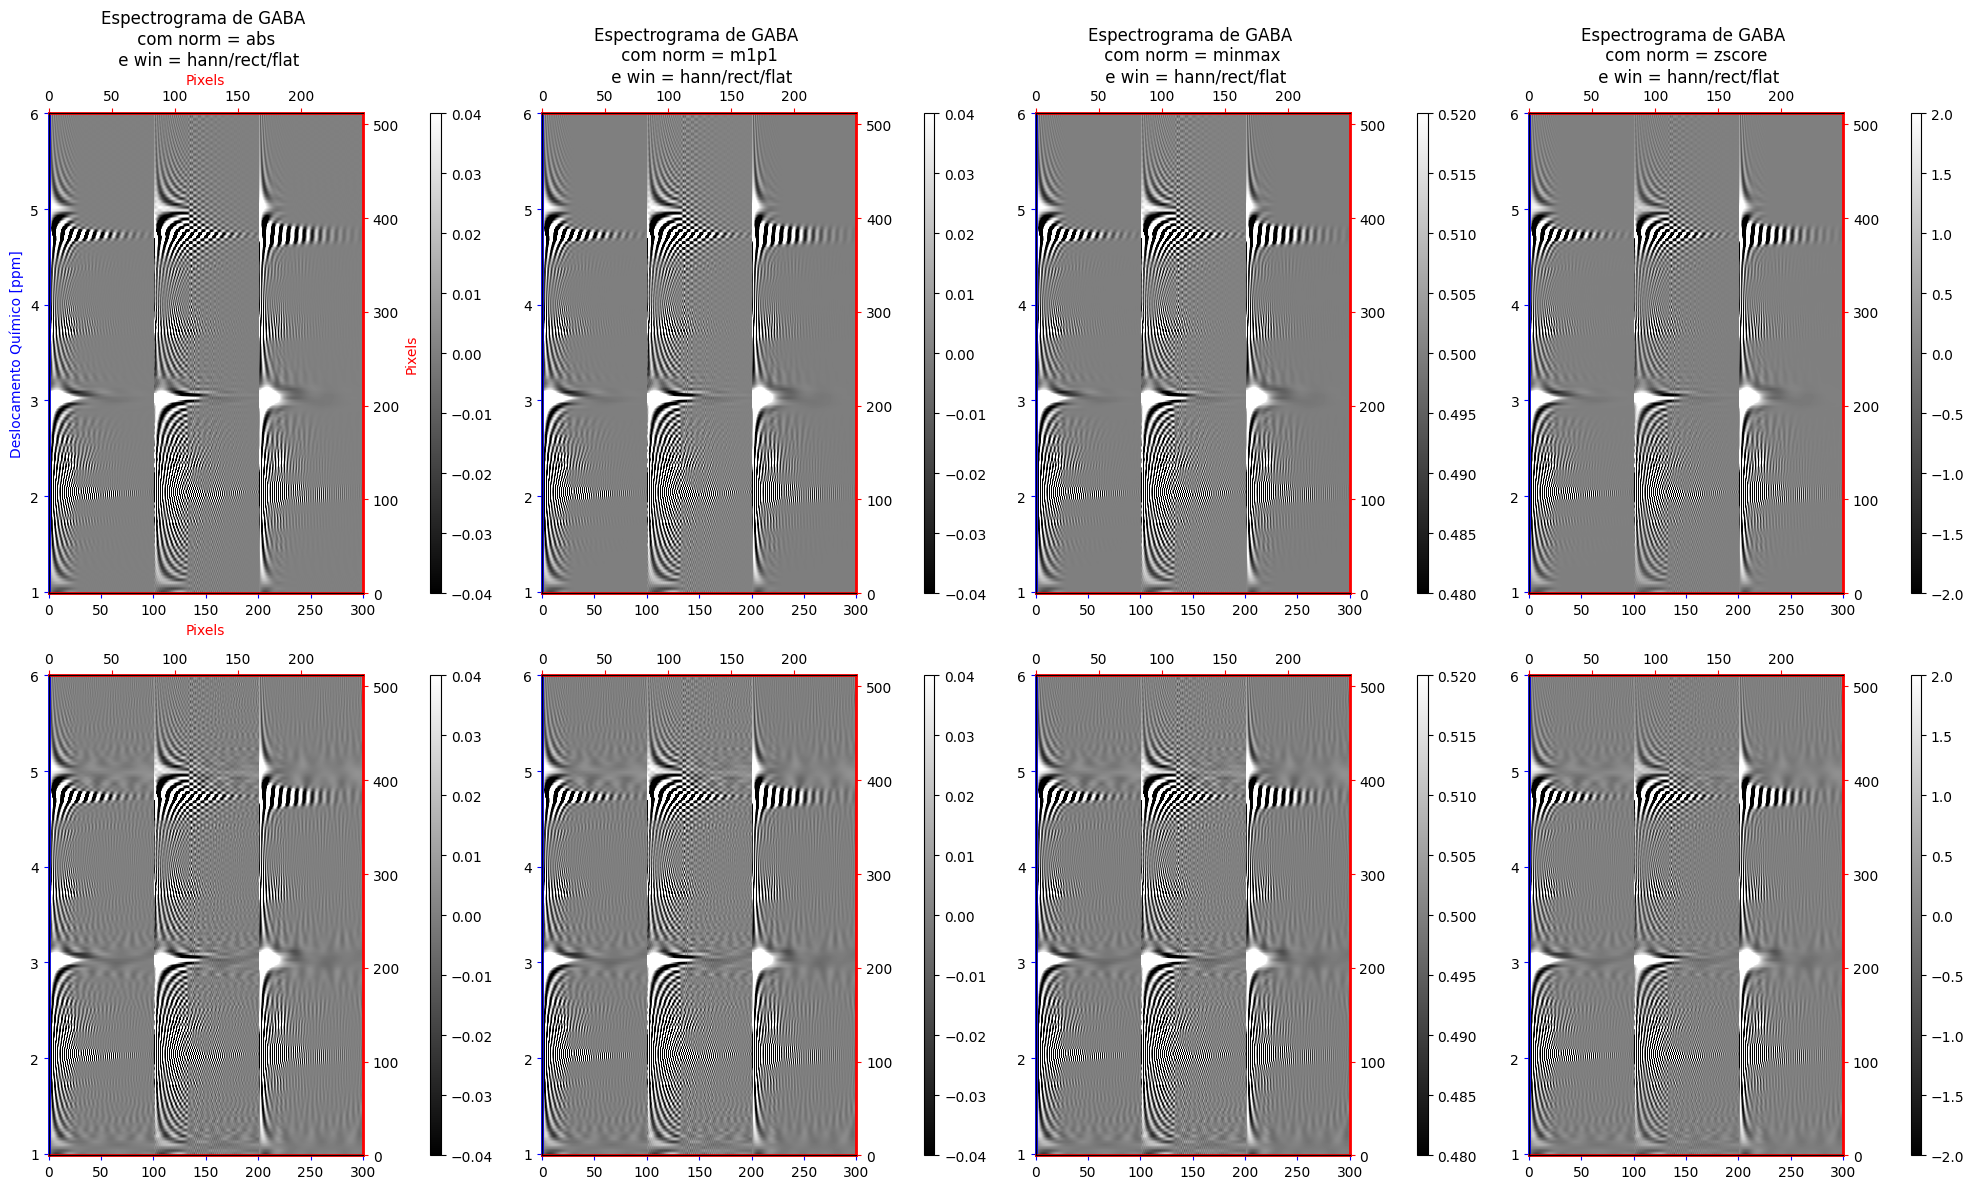

In [14]:
fig,ax = plt.subplots(2,4,figsize=(20,12))

for i in range(len(norm_)):
    if norm_[i] == 'abs' or norm_[i] == 'm1p1':
        vmin_ = -0.04
        vmax_ = 0.04
    elif norm_[i] == 'minmax':
        vmin_ = 0.48
        vmax_ = 0.52
    else:
        vmin_ = -2
        vmax_ = 2
    im = ax.flat[i].imshow(np.real(concat_by_norm_gt['norm_'+norm_[i]][idx_freq_1ppm[0][0]:idx_freq_6ppm[0][0],:]), origin='lower', aspect='auto',cmap='gray',vmin=vmin_,vmax=vmax_,
              extent = (0,concat_by_norm_gt['norm_'+norm_[i]].shape[-1],np.flip(spgram_wn_gt['norm_'+norm_[i]]['window_'+win_name[0]][2])[idx_freq_1ppm[i][0]],np.flip(spgram_wn_gt['norm_'+norm_[0]]['window_'+win_name[0]][2])[idx_freq_6ppm[i][0]]))
    fig.colorbar(im, ax=ax.flat[i], pad = 0.15, aspect=45)
    im = ax.flat[i + 4].imshow(np.real(concat_by_norm_ns['norm_'+norm_[i]][idx_freq_1ppm[0][0]:idx_freq_6ppm[0][0],:]), origin='lower', aspect='auto',cmap='gray',vmin=vmin_,vmax=vmax_,
              extent = (0,concat_by_norm_ns['norm_'+norm_[i]].shape[-1],np.flip(spgram_wn_ns['norm_'+norm_[i]]['window_'+win_name[0]][2])[idx_freq_1ppm[i][0]],np.flip(spgram_wn_ns['norm_'+norm_[0]]['window_'+win_name[0]][2])[idx_freq_6ppm[i][0]]))
    fig.colorbar(im, ax=ax.flat[i+4], pad = 0.15, aspect=45)

for i in range(8):
    par1 = ax.flat[i].twiny()  # Additional x-axis
    par2 = ax.flat[i].twinx()  # Additional y-axis
    if i < 4:
        ax.flat[i].set_title('Espectrograma de GABA \n com norm = '+norm_[i]+' \n e win = hann/rect/flat')
    if  i == 0:
        ax.flat[i].set_xlabel('Pixels')
        ax.flat[i].set_ylabel('Deslocamento Químico [ppm]')
        ax.flat[i].xaxis.label.set_color('r')
        ax.flat[i].yaxis.label.set_color('b')
    ax.flat[i].spines['left'].set_visible(True)
    ax.flat[i].spines['bottom'].set_visible(True)
    ax.flat[i].spines['left'].set_color('b')
    ax.flat[i].spines['bottom'].set_color('r')
    ax.flat[i].spines['left'].set_linewidth(2)
    ax.flat[i].spines['bottom'].set_linewidth(2)
    # Set the position of the additional axes
    par1.spines['top'].set_position(('axes', 1))
    par2.spines['right'].set_position(('axes', 1))
    # Customize the additional axes
    par1.set_xlim(0,spgram_wn_gt['norm_'+norm_[0]]['window_'+win_name[0]][0].shape[2])
    par2.set_ylim(0,spgram_wn_gt['norm_'+norm_[0]]['window_'+win_name[0]][0].shape[1])

    if i == 0:
        par1.set_xlabel("Pixels")
        par2.set_ylabel("Pixels")
        par1.xaxis.label.set_color('r')
        par2.yaxis.label.set_color('r')
    # Turn off unwanted spines for clarity
    par1.spines['top'].set_visible(True)
    par2.spines['right'].set_visible(True)
    par2.spines['right'].set_color('r')
    par1.spines['top'].set_color('r')
    par2.spines['right'].set_linewidth(2)
    par1.spines['top'].set_linewidth(2)
    # Synchronize the tick positions of the host and the twin axes
    ax.flat[i].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, labeltop=False,color='b')
    par1.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True,color ='r')
    ax.flat[i].tick_params(axis='y', which='both', left=True, right=False, labelleft=True, labelright=False,color='b')
    par2.tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True,color='r')


plt.tight_layout()
if test_not_save == False:
    plt.savefig('./relatorio_imagens/imagens_wn/spgram_varying_wn_norms_and_winds_ns_gt.png')

### 2.2 Largura dos picos x win x norm

A largura dos picos é avaliada pelas projeções na frequência: Proj(Espectrograma) e Proj(|Espectrograma|).

Da observação de Proj(|Espectrograma|):
- Para todas as normas, o formato dos picos obtidos pela janela hann e rect são muito parecidos, sendo o formato dos picos obtidos pela janela flat o mais diferente, e mais largo.
- Não há diferenças visíveis no formato dos picos entre normas.
- Pela medição de FWHM, e por análise visual, entende-se que a janela flat origina picos mais largos.
- Considerando o formato dos picos e FWHM, não parece haver diferença de largura entre picos com janela hann e rect, apesar de ter-se essa impressão visual ao olhar o espectrograma.

Da observação das Proj(Espectrograma):
- Para essa projeção, as janelas tendem a formar projeções diferentes entre si (curvas não se sobrepõem).
- Nesse caso, normas diferentes levam a picos com formatos diferentes, sendo as normas abs e zscore as que geram picos mais semelhantes entre si. - Diferença entre projeções de normas diferentes deve ter origem na intensidade dos valores positivos e negativos que se distribuem de forma diferente segundo a norma...Como Proj(|Espectrograma|) soma a magnitude de todas as contribuições, essas diferenças não são percebidas nessa projeção.
- O pico de Glx se torna muito mal definido nessa projeção para as condições de geração do espectrograma escolhidas (hop e mfft).
- Novamente, apesar da impressão visual, não se conclui que rect leva a picos mais finos que hann, isso acontece para o pico de NAA, mas não para o pico de GABA. - Erro na maneira como a métrica FWHM é calculada considerando o formato dos picos ou as janelas impactam a largura de diferentes picos de maneira diferente? É necessário observar mais picos para entender.
- Novamente, a janela flat leva a picos mais largos. 


In [15]:
idx_fwhm_gt = {}
idx_fwhm_real_gt = {}
idx_fwhm_ns = {}
idx_fwhm_real_ns = {}
for i in range(len(norm_)):
    list_projections_abs_gt = []
    list_projections_real_gt = []
    list_projections_abs_ns = []
    list_projections_real_ns = []
    list_of_ppm_spects = []
    idx_fwhm_gt['norm_'+norm_[i]] = {}
    idx_fwhm_real_gt['norm_'+norm_[i]] = {}
    idx_fwhm_ns['norm_'+norm_[i]] = {}
    idx_fwhm_real_ns['norm_'+norm_[i]] = {}
    for j in range(len(window_)):
        if norm_[i] == 'minmax':
            #correcao pois não está centralizado em 0
            aux_mean_minmax_gt = np.mean(np.real(spgram_wn_gt['norm_'+norm_[i]]['window_'+win_name[j]][0]),axis=(1,2),keepdims=True)
            aux_minmax_gt = np.real(spgram_wn_gt['norm_'+norm_[i]]['window_'+win_name[j]][0]) - aux_mean_minmax_gt
            aux_abs_gt = np.sum(np.abs(aux_minmax_gt),axis=2)
            aux_real_gt = np.sum(aux_minmax_gt,axis=2)
            #------------------------------------------------------------
            aux_mean_minmax_ns = np.mean(np.real(spgram_wn_ns['norm_'+norm_[i]]['window_'+win_name[j]][0]),axis=(1,2),keepdims=True)
            aux_minmax_ns = np.real(spgram_wn_ns['norm_'+norm_[i]]['window_'+win_name[j]][0]) - aux_mean_minmax_ns
            aux_abs_ns = np.sum(np.abs(aux_minmax_ns),axis=2)
            aux_real_ns = np.sum(aux_minmax_ns,axis=2)
        else:
            aux_abs_gt = np.sum(np.abs(np.real(spgram_wn_gt['norm_'+norm_[i]]['window_'+win_name[j]][0])),axis=2)
            aux_real_gt = np.sum(np.real(spgram_wn_gt['norm_'+norm_[i]]['window_'+win_name[j]][0]),axis=2)
            aux_abs_ns = np.sum(np.abs(np.real(spgram_wn_ns['norm_'+norm_[i]]['window_'+win_name[j]][0])),axis=2)
            aux_real_ns = np.sum(np.real(spgram_wn_ns['norm_'+norm_[i]]['window_'+win_name[j]][0]),axis=2)

        list_projections_abs_gt.append(aux_abs_gt)
        list_projections_real_gt.append(aux_real_gt)
        list_projections_abs_ns.append(aux_abs_ns)
        list_projections_real_ns.append(aux_real_ns)
        list_of_ppm_spects.append(spgram_wn_gt['norm_'+norm_[i]]['window_'+win_name[j]][2])
        idx_fwhm_gt['norm_'+norm_[i]]['window_'+win_name[j]] = {}
        idx_fwhm_real_gt['norm_'+norm_[i]]['window_'+win_name[j]] = {}
        idx_fwhm_ns['norm_'+norm_[i]]['window_'+win_name[j]] = {}
        idx_fwhm_real_ns['norm_'+norm_[i]]['window_'+win_name[j]] = {}

    aux, aux_idx_NAA_abs_gt = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs_gt,list_peak_idx=idx_freq_NAA[i],list_ppm=list_of_ppm_spects,peak_ppm_plus=2.50,peak_ppm_minus=1.50,preference='positive')
    aux, aux_idx_NAA_abs_ns = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs_ns,list_peak_idx=idx_freq_NAA[i],list_ppm=list_of_ppm_spects,peak_ppm_plus=2.50,peak_ppm_minus=1.50,preference='positive')
    aux, aux_idx_GABA_abs_gt = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs_gt,list_peak_idx=idx_freq_GABA[i],list_ppm=list_of_ppm_spects,peak_ppm_plus=3.50,peak_ppm_minus=2.50,preference='positive')
    aux, aux_idx_GABA_abs_ns = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs_ns,list_peak_idx=idx_freq_GABA[i],list_ppm=list_of_ppm_spects,peak_ppm_plus=3.50,peak_ppm_minus=2.50,preference='positive')
    aux, aux_idx_Glx_abs_gt = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs_gt,list_peak_idx=idx_freq_Glx[i],list_ppm=list_of_ppm_spects,peak_ppm_plus=4.00,peak_ppm_minus=3.50,preference='positive')
    aux, aux_idx_Glx_abs_ns = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs_ns,list_peak_idx=idx_freq_Glx[i],list_ppm=list_of_ppm_spects,peak_ppm_plus=4.00,peak_ppm_minus=3.50,preference='positive')
    
    aux, aux_idx_NAA_real_gt = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real_gt,list_peak_idx=idx_freq_NAA[i],list_ppm=list_of_ppm_spects,peak_ppm_plus=2.50,peak_ppm_minus=1.50,preference='negative')
    aux, aux_idx_NAA_real_ns = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real_ns,list_peak_idx=idx_freq_NAA[i],list_ppm=list_of_ppm_spects,peak_ppm_plus=2.50,peak_ppm_minus=1.50,preference='negative')
    aux, aux_idx_GABA_real_gt = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real_gt,list_peak_idx=idx_freq_GABA[i],list_ppm=list_of_ppm_spects,peak_ppm_plus=3.50,peak_ppm_minus=2.50,preference='positive')
    aux, aux_idx_GABA_real_ns = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real_ns,list_peak_idx=idx_freq_GABA[i],list_ppm=list_of_ppm_spects,peak_ppm_plus=3.50,peak_ppm_minus=2.50,preference='positive')
    aux, aux_idx_Glx_real_gt = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real_gt,list_peak_idx=idx_freq_Glx[i],list_ppm=list_of_ppm_spects,peak_ppm_plus=4.00,peak_ppm_minus=3.50,preference='positive')
    aux, aux_idx_Glx_real_ns = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real_ns,list_peak_idx=idx_freq_Glx[i],list_ppm=list_of_ppm_spects,peak_ppm_plus=4.00,peak_ppm_minus=3.50,preference='positive')

    for j in range(len(window_)):
        idx_fwhm_gt['norm_'+norm_[i]]['window_'+win_name[j]]['NAA'] = aux_idx_NAA_abs_gt[j]
        idx_fwhm_gt['norm_'+norm_[i]]['window_'+win_name[j]]['GABA'] = aux_idx_GABA_abs_gt[j]
        idx_fwhm_gt['norm_'+norm_[i]]['window_'+win_name[j]]['Glx'] = aux_idx_Glx_abs_gt[j]

        idx_fwhm_ns['norm_'+norm_[i]]['window_'+win_name[j]]['NAA'] = aux_idx_NAA_abs_ns[j]
        idx_fwhm_ns['norm_'+norm_[i]]['window_'+win_name[j]]['GABA'] = aux_idx_GABA_abs_ns[j]
        idx_fwhm_ns['norm_'+norm_[i]]['window_'+win_name[j]]['Glx'] = aux_idx_Glx_abs_ns[j]
        
        idx_fwhm_real_gt['norm_'+norm_[i]]['window_'+win_name[j]]['NAA'] = aux_idx_NAA_real_gt[j]
        idx_fwhm_real_gt['norm_'+norm_[i]]['window_'+win_name[j]]['GABA'] = aux_idx_GABA_real_gt[j]
        idx_fwhm_real_gt['norm_'+norm_[i]]['window_'+win_name[j]]['Glx'] = aux_idx_Glx_real_gt[j]
        
        idx_fwhm_real_ns['norm_'+norm_[i]]['window_'+win_name[j]]['NAA'] = aux_idx_NAA_real_ns[j]
        idx_fwhm_real_ns['norm_'+norm_[i]]['window_'+win_name[j]]['GABA'] = aux_idx_GABA_real_ns[j]
        idx_fwhm_real_ns['norm_'+norm_[i]]['window_'+win_name[j]]['Glx'] = aux_idx_Glx_real_ns[j]

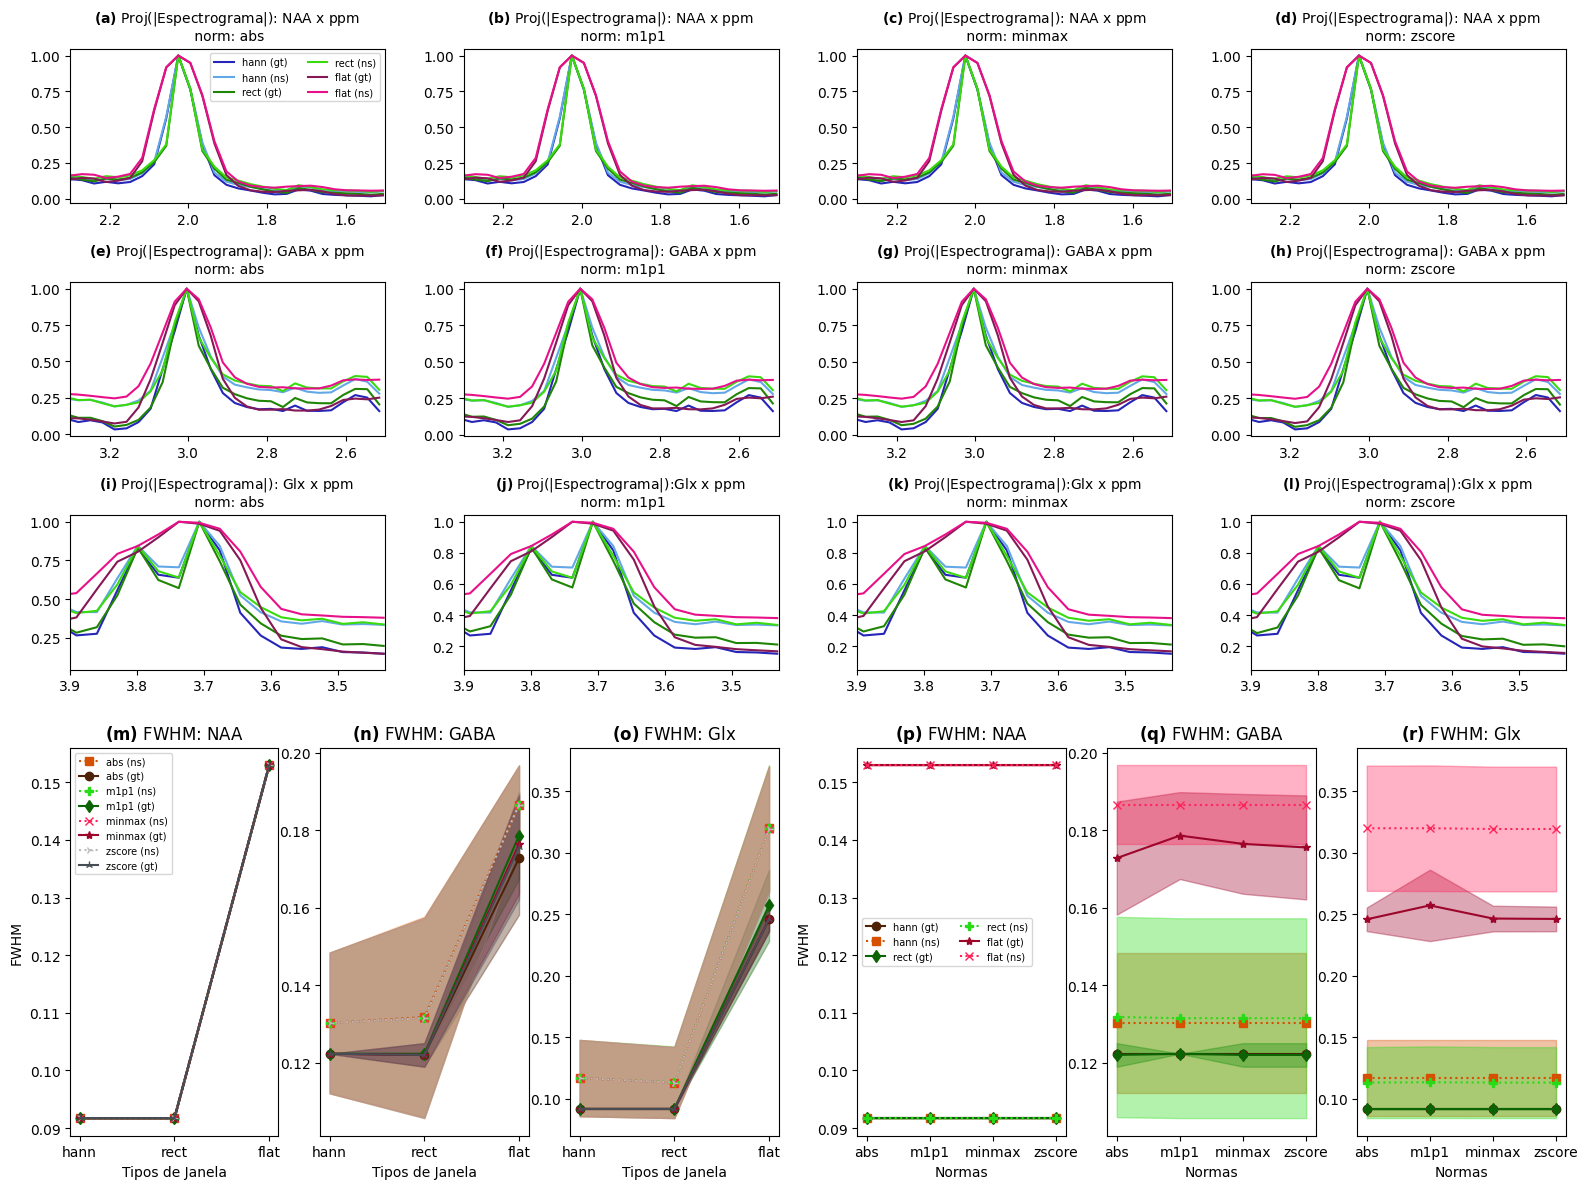

In [20]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(16, 12))
outer_grid = fig.add_gridspec(5, 4)
ax1 = outer_grid[0, 0].subgridspec(1,1).subplots()
ax2 = outer_grid[0, 1].subgridspec(1,1).subplots()
ax3 = outer_grid[0, 2].subgridspec(1,1).subplots() 
ax4 = outer_grid[0, 3].subgridspec(1,1).subplots()
ax5 = outer_grid[1, 0].subgridspec(1,1).subplots()   
ax6 = outer_grid[1, 1].subgridspec(1,1).subplots()
ax7 = outer_grid[1, 2].subgridspec(1,1).subplots()
ax8 = outer_grid[1, 3].subgridspec(1,1).subplots()
ax9 = outer_grid[2, 0].subgridspec(1,1).subplots()   
ax10 = outer_grid[2, 1].subgridspec(1,1).subplots()
ax11 = outer_grid[2, 2].subgridspec(1,1).subplots()
ax12 = outer_grid[2, 3].subgridspec(1,1).subplots()
ax13 = outer_grid[3:, :2].subgridspec(1,3, wspace=0.2, hspace=0.1)
ax13_in = ax13.subplots()
ax14 = outer_grid[3:, 2:].subgridspec(1,3, wspace=0.2, hspace=0.1)
ax14_in = ax14.subplots()

ax1.set_xlim(2.3,1.5) 
ax2.set_xlim(2.3,1.5) 
ax3.set_xlim(2.3,1.5) 
ax4.set_xlim(2.3,1.5) 

ax5.set_xlim(3.3,2.5)
ax6.set_xlim(3.3,2.5)
ax7.set_xlim(3.3,2.5)
ax8.set_xlim(3.3,2.5)

ax9.set_xlim(3.9,3.43)  
ax10.set_xlim(3.9,3.43)  
ax11.set_xlim(3.9,3.43)  
ax12.set_xlim(3.9,3.43)  


colors = ['#2525b8','#1f8505','#851855','#63a8e6','#39db0f','#e81089']
colors_sec = ['#3232fc','#3cff0a','#ff2ba2','#6db8fc','#41f711','#fa0f93']
ax_list = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12]
for i in range(len(norm_)):
    for j in range(len(window_)):
        if i == 2:
            added_space = 0
        else:
            added_space = 0
        if norm_[i] == 'minmax':
            aux = np.mean(np.sum(np.abs(np.real(spgram_wn_gt['norm_'+norm_[i]]['window_'+win_name[j]][0])-0.5),axis=2),axis=0)
            aux_ns = np.mean(np.sum(np.abs(np.real(spgram_wn_ns['norm_'+norm_[i]]['window_'+win_name[j]][0]-0.5)),axis=2),axis=0)
        else:
            aux = np.mean(np.sum(np.abs(np.real(spgram_wn_gt['norm_'+norm_[i]]['window_'+win_name[j]][0])),axis=2),axis=0)
            aux_ns = np.mean(np.sum(np.abs(np.real(spgram_wn_ns['norm_'+norm_[i]]['window_'+win_name[j]][0])),axis=2),axis=0)
        aux1d5 = utils.give_idx_ppm_point(ppm_array=spgram_wn_gt['norm_'+norm_[i]]['window_'+win_name[j]][2],ppm_point=1.5)
        aux2d5 = utils.give_idx_ppm_point(ppm_array=spgram_wn_gt['norm_'+norm_[i]]['window_'+win_name[j]][2],ppm_point=2.5)
        aux3d5 = utils.give_idx_ppm_point(ppm_array=spgram_wn_gt['norm_'+norm_[i]]['window_'+win_name[j]][2],ppm_point=3.5)
        aux4d2 = utils.give_idx_ppm_point(ppm_array=spgram_wn_gt['norm_'+norm_[i]]['window_'+win_name[j]][2],ppm_point=4.2)
        aux3d43 = utils.give_idx_ppm_point(ppm_array=spgram_wn_gt['norm_'+norm_[i]]['window_'+win_name[j]][2],ppm_point=3.43)
        ax_list[i].plot(np.flip(spgram_wn_gt['norm_'+norm_[i]]['window_'+win_name[j]][2])[aux1d5:aux2d5],aux[aux1d5:aux2d5]/np.max(aux[aux1d5:aux2d5])+added_space*j,label=win_name[j]+' (gt)',color=colors[j])
        ax_list[i].plot(np.flip(spgram_wn_ns['norm_'+norm_[i]]['window_'+win_name[j]][2])[aux1d5:aux2d5],aux_ns[aux1d5:aux2d5]/np.max(aux_ns[aux1d5:aux2d5])+added_space*j,label=win_name[j]+' (ns)',color=colors[j+3])
        ax_list[i+4].plot(np.flip(spgram_wn_gt['norm_'+norm_[i]]['window_'+win_name[j]][2])[aux2d5:aux3d5],aux[aux2d5:aux3d5]/np.max(aux[aux2d5:aux3d5])+added_space*j,label=win_name[j]+' (gt)',color=colors[j])
        ax_list[i+4].plot(np.flip(spgram_wn_ns['norm_'+norm_[i]]['window_'+win_name[j]][2])[aux2d5:aux3d5],aux_ns[aux2d5:aux3d5]/np.max(aux_ns[aux2d5:aux3d5])+added_space*j,label=win_name[j]+' (ns)',color=colors[j+3])
        ax_list[i+8].plot(np.flip(spgram_wn_gt['norm_'+norm_[i]]['window_'+win_name[j]][2])[aux3d43:aux4d2],aux[aux3d43:aux4d2]/np.max(aux[aux3d43:aux4d2])+added_space*j,label=win_name[j]+' (gt)',color=colors[j])
        ax_list[i+8].plot(np.flip(spgram_wn_ns['norm_'+norm_[i]]['window_'+win_name[j]][2])[aux3d43:aux4d2],aux_ns[aux3d43:aux4d2]/np.max(aux_ns[aux3d43:aux4d2])+added_space*j,label=win_name[j]+' (ns)',color=colors[j+3]) 
       

ax1.legend(loc='upper right', ncols=2,fontsize=7)
ax1.set_title('$\mathbf{(a)}$ Proj(|Espectrograma|): NAA x ppm \n norm: '+norm_[0],fontsize = 10)
ax2.set_title('$\mathbf{(b)}$ Proj(|Espectrograma|): NAA x ppm \n norm: '+norm_[1],fontsize = 10)
ax3.set_title('$\mathbf{(c)}$ Proj(|Espectrograma|): NAA x ppm \n norm: '+norm_[2],fontsize = 10)
ax4.set_title('$\mathbf{(d)}$ Proj(|Espectrograma|): NAA x ppm \n norm: '+norm_[3],fontsize = 10)
ax5.set_title('$\mathbf{(e)}$ Proj(|Espectrograma|): GABA x ppm \n norm: '+norm_[0],fontsize = 10)
ax6.set_title('$\mathbf{(f)}$ Proj(|Espectrograma|): GABA x ppm \n norm: '+norm_[1],fontsize = 10)
ax7.set_title('$\mathbf{(g)}$ Proj(|Espectrograma|): GABA x ppm \n norm: '+norm_[2],fontsize = 10)
ax8.set_title('$\mathbf{(h)}$ Proj(|Espectrograma|): GABA x ppm \n norm: '+norm_[3],fontsize = 10)
ax9.set_title('$\mathbf{(i)}$ Proj(|Espectrograma|): Glx x ppm \n norm: '+norm_[0],fontsize = 10)
ax10.set_title('$\mathbf{(j)}$ Proj(|Espectrograma|):Glx x ppm \n norm: '+norm_[1],fontsize = 10)
ax11.set_title('$\mathbf{(k)}$ Proj(|Espectrograma|):Glx x ppm \n norm: '+norm_[2],fontsize = 10)
ax12.set_title('$\mathbf{(l)}$ Proj(|Espectrograma|):Glx x ppm \n norm: '+norm_[3],fontsize = 10)

marker_list = ['o','d','*','2','s','P','x','4']
color_list = ['#4f2207','#0c6304','#9e052b','#474d54','#d65002','#27db16','#ff245a','#b9bbbd']
label_list = ['NAA','GABA','Glx']
for k in range(3):
    for i in range(len(norm_)):
        ax13_in[k].plot(win_name,ns_metrics['fwhm_wn'][label_list[k]][i]['mean'],color=color_list[i+4],marker=marker_list[i+4],label=norm_[i]+' (ns)', linestyle='dotted')
        ax13_in[k].fill_between(win_name,np.array(ns_metrics['fwhm_wn'][label_list[k]][i]['mean']) - np.array(ns_metrics['fwhm_wn'][label_list[k]][i]['std']), 
                np.array(ns_metrics['fwhm_wn'][label_list[k]][i]['mean']) + np.array(ns_metrics['fwhm_wn'][label_list[k]][i]['std']), alpha=0.35, color=color_list[i+4])
        ax13_in[k].plot(win_name,gt_metrics['fwhm_wn'][label_list[k]][i]['mean'],color=color_list[i],marker=marker_list[i],label=norm_[i]+' (gt)')
        ax13_in[k].fill_between(win_name,np.array(gt_metrics['fwhm_wn'][label_list[k]][i]['mean']) - np.array(gt_metrics['fwhm_wn'][label_list[k]][i]['std']), 
                np.array(gt_metrics['fwhm_wn'][label_list[k]][i]['mean']) + np.array(gt_metrics['fwhm_wn'][label_list[k]][i]['std']), alpha=0.35, color=color_list[i])
        ax13_in[k].set_xlabel('Tipos de Janela')
        if k == 0:
            ax13_in[k].set_ylabel('FWHM')
    for j in range(len(win_name)):
        aux = []
        aux_std = []
        aux_ns = []
        aux_ns_std = []
        for i in range(len(norm_)):
            aux.append(gt_metrics['fwhm_wn'][label_list[k]][i]['mean'][j])
            aux_std.append(gt_metrics['fwhm_wn'][label_list[k]][i]['std'][j])
            aux_ns.append(ns_metrics['fwhm_wn'][label_list[k]][i]['mean'][j])
            aux_ns_std.append(ns_metrics['fwhm_wn'][label_list[k]][i]['std'][j])

        ax14_in[k].plot(norm_,aux,color=color_list[j],marker=marker_list[j],label=win_name[j]+' (gt)')
        ax14_in[k].fill_between(norm_,np.array(aux) - np.array(aux_std), 
                    np.array(aux) + np.array(aux_std), alpha=0.35, color=color_list[j])
        ax14_in[k].plot(norm_,aux_ns,color=color_list[j+4],marker=marker_list[j+4], linestyle='dotted', label=win_name[j]+' (ns)')
        ax14_in[k].fill_between(norm_,np.array(aux_ns) - np.array(aux_ns_std), 
                    np.array(aux_ns) + np.array(aux_ns_std), alpha=0.35, color=color_list[j+4])
        ax14_in[k].set_xlabel('Normas')
        if k==0:
            ax14_in[k].set_ylabel('FWHM')

ax13_in[0].legend(loc='upper left',fontsize=7)
ax14_in[0].legend(loc='center left', ncols=2,fontsize=7)
ax13_in[0].set_title('$\mathbf{(m)}$ FWHM: NAA')
ax13_in[1].set_title('$\mathbf{(n)}$ FWHM: GABA')
ax13_in[2].set_title('$\mathbf{(o)}$ FWHM: Glx')
ax14_in[0].set_title('$\mathbf{(p)}$ FWHM: NAA')
ax14_in[1].set_title('$\mathbf{(q)}$ FWHM: GABA')
ax14_in[2].set_title('$\mathbf{(r)}$ FWHM: Glx')

plt.tight_layout()
if test_not_save == False:
    plt.savefig('./relatorio_imagens/imagens_wn/spgram_varying_wn_fwhm_abs.png')


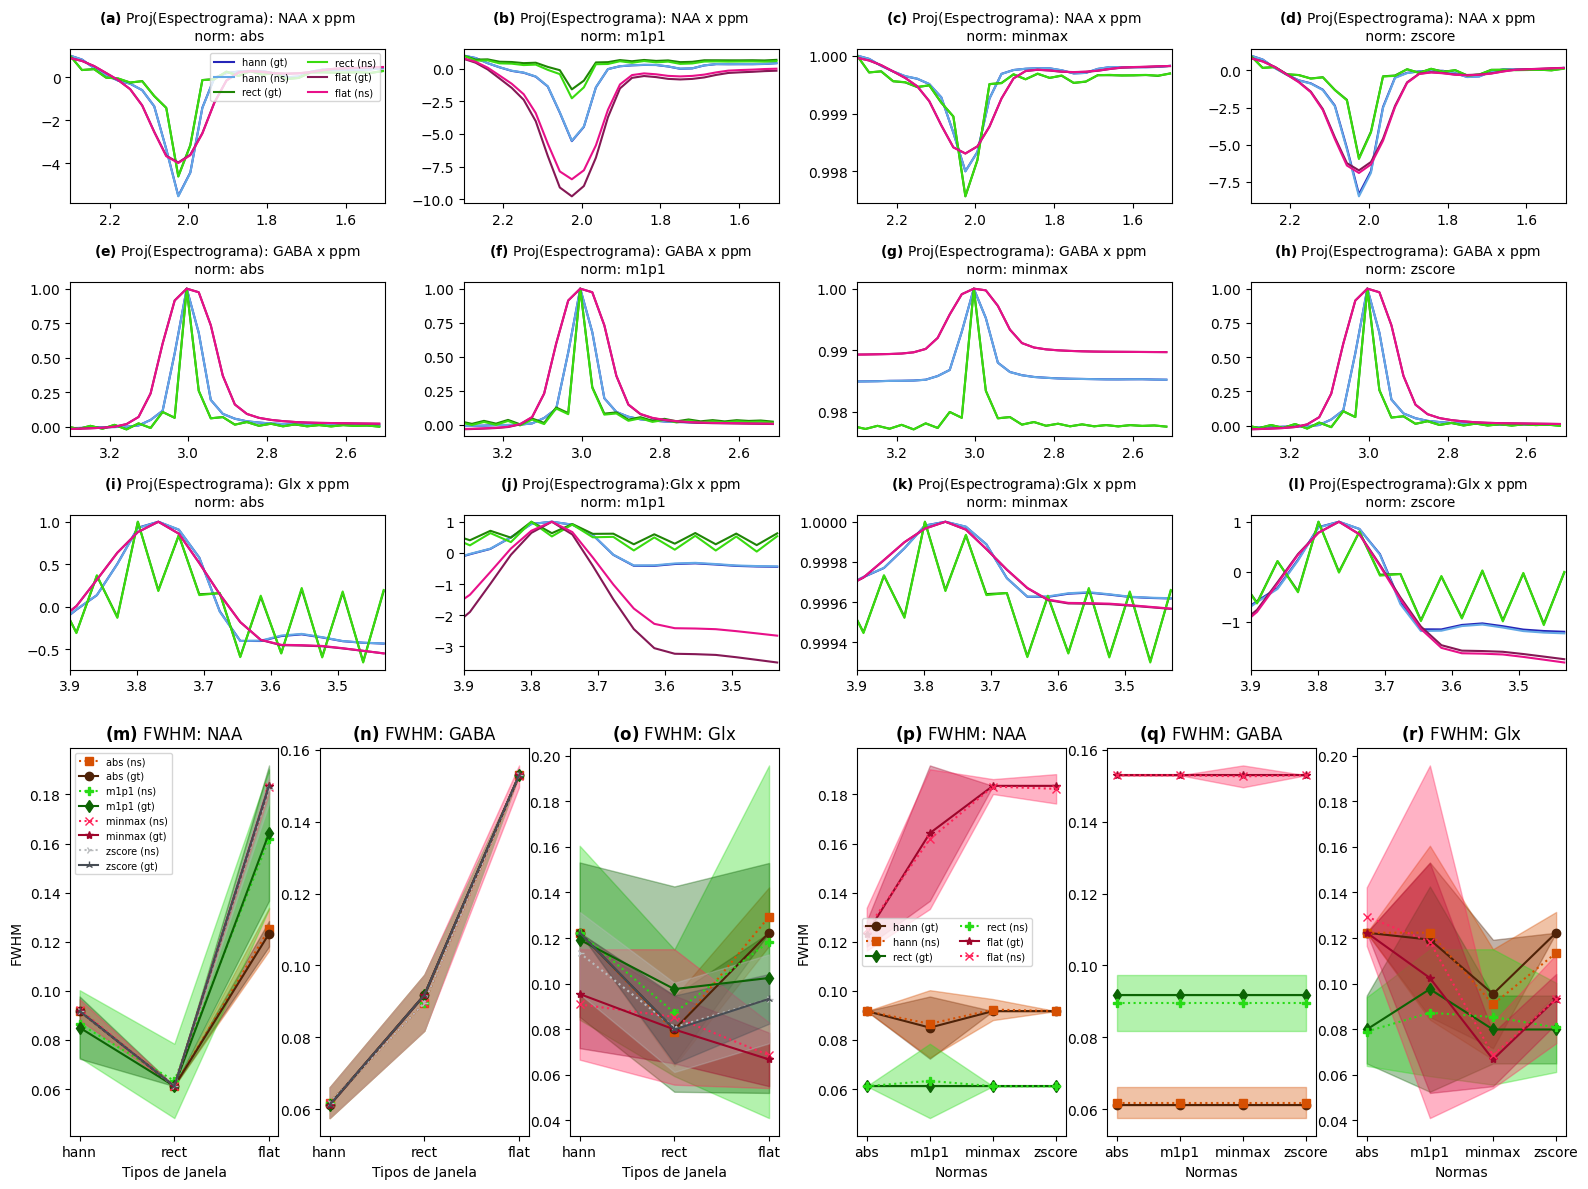

In [21]:
fig = plt.figure(figsize=(16, 12))
outer_grid = fig.add_gridspec(5, 4)
ax1 = outer_grid[0, 0].subgridspec(1,1).subplots()
ax2 = outer_grid[0, 1].subgridspec(1,1).subplots()
ax3 = outer_grid[0, 2].subgridspec(1,1).subplots() 
ax4 = outer_grid[0, 3].subgridspec(1,1).subplots()
ax5 = outer_grid[1, 0].subgridspec(1,1).subplots()   
ax6 = outer_grid[1, 1].subgridspec(1,1).subplots()
ax7 = outer_grid[1, 2].subgridspec(1,1).subplots()
ax8 = outer_grid[1, 3].subgridspec(1,1).subplots()
ax9 = outer_grid[2, 0].subgridspec(1,1).subplots()   
ax10 = outer_grid[2, 1].subgridspec(1,1).subplots()
ax11 = outer_grid[2, 2].subgridspec(1,1).subplots()
ax12 = outer_grid[2, 3].subgridspec(1,1).subplots()
ax13 = outer_grid[3:, :2].subgridspec(1,3, wspace=0.2, hspace=0.1)
ax13_in = ax13.subplots()
ax14 = outer_grid[3:, 2:].subgridspec(1,3, wspace=0.2, hspace=0.1)
ax14_in = ax14.subplots()

ax1.set_xlim(2.3,1.5) 
ax2.set_xlim(2.3,1.5) 
ax3.set_xlim(2.3,1.5) 
ax4.set_xlim(2.3,1.5) 

ax5.set_xlim(3.3,2.5)
ax6.set_xlim(3.3,2.5)
ax7.set_xlim(3.3,2.5)
ax8.set_xlim(3.3,2.5)

ax9.set_xlim(3.9,3.43)  
ax10.set_xlim(3.9,3.43)  
ax11.set_xlim(3.9,3.43)  
ax12.set_xlim(3.9,3.43)  


colors = ['#2525b8','#1f8505','#851855','#63a8e6','#39db0f','#e81089']
colors_sec = ['#3232fc','#3cff0a','#ff2ba2','#6db8fc','#41f711','#fa0f93']
ax_list = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12]
for i in range(len(norm_)):
    for j in range(len(window_)):
        if i == 2:
            added_space = 0
        else:
            added_space = 0
        aux = np.mean(np.sum(np.real(spgram_wn_gt['norm_'+norm_[i]]['window_'+win_name[j]][0]),axis=2),axis=0)
        aux_ns = np.mean(np.sum(np.real(spgram_wn_ns['norm_'+norm_[i]]['window_'+win_name[j]][0]),axis=2),axis=0)
        aux1d5 = utils.give_idx_ppm_point(ppm_array=spgram_wn_gt['norm_'+norm_[i]]['window_'+win_name[j]][2],ppm_point=1.5)
        aux2d5 = utils.give_idx_ppm_point(ppm_array=spgram_wn_gt['norm_'+norm_[i]]['window_'+win_name[j]][2],ppm_point=2.5)
        aux3d5 = utils.give_idx_ppm_point(ppm_array=spgram_wn_gt['norm_'+norm_[i]]['window_'+win_name[j]][2],ppm_point=3.5)
        aux4d2 = utils.give_idx_ppm_point(ppm_array=spgram_wn_gt['norm_'+norm_[i]]['window_'+win_name[j]][2],ppm_point=4.2)
        aux3d43 = utils.give_idx_ppm_point(ppm_array=spgram_wn_gt['norm_'+norm_[i]]['window_'+win_name[j]][2],ppm_point=3.43)
        ax_list[i].plot(np.flip(spgram_wn_gt['norm_'+norm_[i]]['window_'+win_name[j]][2])[aux1d5:aux2d5],aux[aux1d5:aux2d5]/np.max(aux[aux1d5:aux2d5])+added_space*j,label=win_name[j]+' (gt)',color=colors[j])
        ax_list[i].plot(np.flip(spgram_wn_ns['norm_'+norm_[i]]['window_'+win_name[j]][2])[aux1d5:aux2d5],aux_ns[aux1d5:aux2d5]/np.max(aux_ns[aux1d5:aux2d5])+added_space*j,label=win_name[j]+' (ns)',color=colors[j+3])
        ax_list[i+4].plot(np.flip(spgram_wn_gt['norm_'+norm_[i]]['window_'+win_name[j]][2])[aux2d5:aux3d5],aux[aux2d5:aux3d5]/np.max(aux[aux2d5:aux3d5])+added_space*j,label=win_name[j]+' (gt)',color=colors[j])
        ax_list[i+4].plot(np.flip(spgram_wn_ns['norm_'+norm_[i]]['window_'+win_name[j]][2])[aux2d5:aux3d5],aux_ns[aux2d5:aux3d5]/np.max(aux_ns[aux2d5:aux3d5])+added_space*j,label=win_name[j]+' (ns)',color=colors[j+3])
        ax_list[i+8].plot(np.flip(spgram_wn_gt['norm_'+norm_[i]]['window_'+win_name[j]][2])[aux3d43:aux4d2],aux[aux3d43:aux4d2]/np.max(aux[aux3d43:aux4d2])+added_space*j,label=win_name[j]+' (gt)',color=colors[j])
        ax_list[i+8].plot(np.flip(spgram_wn_ns['norm_'+norm_[i]]['window_'+win_name[j]][2])[aux3d43:aux4d2],aux_ns[aux3d43:aux4d2]/np.max(aux_ns[aux3d43:aux4d2])+added_space*j,label=win_name[j]+' (ns)',color=colors[j+3]) 


ax1.legend(loc='upper right', ncols=2,fontsize=7)
ax1.set_title('$\mathbf{(a)}$ Proj(Espectrograma): NAA x ppm \n norm: '+norm_[0],fontsize = 10)
ax2.set_title('$\mathbf{(b)}$ Proj(Espectrograma): NAA x ppm \n norm: '+norm_[1],fontsize = 10)
ax3.set_title('$\mathbf{(c)}$ Proj(Espectrograma): NAA x ppm \n norm: '+norm_[2],fontsize = 10)
ax4.set_title('$\mathbf{(d)}$ Proj(Espectrograma): NAA x ppm \n norm: '+norm_[3],fontsize = 10)
ax5.set_title('$\mathbf{(e)}$ Proj(Espectrograma): GABA x ppm \n norm: '+norm_[0],fontsize = 10)
ax6.set_title('$\mathbf{(f)}$ Proj(Espectrograma): GABA x ppm \n norm: '+norm_[1],fontsize = 10)
ax7.set_title('$\mathbf{(g)}$ Proj(Espectrograma): GABA x ppm \n norm: '+norm_[2],fontsize = 10)
ax8.set_title('$\mathbf{(h)}$ Proj(Espectrograma): GABA x ppm \n norm: '+norm_[3],fontsize = 10)
ax9.set_title('$\mathbf{(i)}$ Proj(Espectrograma): Glx x ppm \n norm: '+norm_[0],fontsize = 10)
ax10.set_title('$\mathbf{(j)}$ Proj(Espectrograma):Glx x ppm \n norm: '+norm_[1],fontsize = 10)
ax11.set_title('$\mathbf{(k)}$ Proj(Espectrograma):Glx x ppm \n norm: '+norm_[2],fontsize = 10)
ax12.set_title('$\mathbf{(l)}$ Proj(Espectrograma):Glx x ppm \n norm: '+norm_[3],fontsize = 10)

marker_list = ['o','d','*','2','s','P','x','4']
color_list = ['#4f2207','#0c6304','#9e052b','#474d54','#d65002','#27db16','#ff245a','#b9bbbd']
label_list = ['NAA','GABA','Glx']
for k in range(3):
    for i in range(len(norm_)):
        ax13_in[k].plot(win_name,ns_metrics['fwhm_wn_real'][label_list[k]][i]['mean'],color=color_list[i+4],marker=marker_list[i+4],label=norm_[i]+' (ns)', linestyle='dotted')
        ax13_in[k].fill_between(win_name,np.array(ns_metrics['fwhm_wn_real'][label_list[k]][i]['mean']) - np.array(ns_metrics['fwhm_wn_real'][label_list[k]][i]['std']), 
                np.array(ns_metrics['fwhm_wn_real'][label_list[k]][i]['mean']) + np.array(ns_metrics['fwhm_wn_real'][label_list[k]][i]['std']), alpha=0.35, color=color_list[i+4])
        ax13_in[k].plot(win_name,gt_metrics['fwhm_wn_real'][label_list[k]][i]['mean'],color=color_list[i],marker=marker_list[i],label=norm_[i]+' (gt)')
        ax13_in[k].fill_between(win_name,np.array(gt_metrics['fwhm_wn_real'][label_list[k]][i]['mean']) - np.array(gt_metrics['fwhm_wn_real'][label_list[k]][i]['std']), 
                np.array(gt_metrics['fwhm_wn_real'][label_list[k]][i]['mean']) + np.array(gt_metrics['fwhm_wn_real'][label_list[k]][i]['std']), alpha=0.35, color=color_list[i])
        ax13_in[k].set_xlabel('Tipos de Janela')
        if k == 0:
            ax13_in[k].set_ylabel('FWHM')
    for j in range(len(win_name)):
        aux = []
        aux_std = []
        aux_ns = []
        aux_ns_std = []
        for i in range(len(norm_)):
            aux.append(gt_metrics['fwhm_wn_real'][label_list[k]][i]['mean'][j])
            aux_std.append(gt_metrics['fwhm_wn_real'][label_list[k]][i]['std'][j])
            aux_ns.append(ns_metrics['fwhm_wn_real'][label_list[k]][i]['mean'][j])
            aux_ns_std.append(ns_metrics['fwhm_wn_real'][label_list[k]][i]['std'][j])

        ax14_in[k].plot(norm_,aux,color=color_list[j],marker=marker_list[j],label=win_name[j]+' (gt)')
        ax14_in[k].fill_between(norm_,np.array(aux) - np.array(aux_std), 
                    np.array(aux) + np.array(aux_std), alpha=0.35, color=color_list[j])
        ax14_in[k].plot(norm_,aux_ns,color=color_list[j+4],marker=marker_list[j+4], linestyle='dotted', label=win_name[j]+' (ns)')
        ax14_in[k].fill_between(norm_,np.array(aux_ns) - np.array(aux_ns_std), 
                    np.array(aux_ns) + np.array(aux_ns_std), alpha=0.35, color=color_list[j+4])
        ax14_in[k].set_xlabel('Normas')
        if k==0:
            ax14_in[k].set_ylabel('FWHM')


ax13_in[0].legend(loc='upper left',fontsize=7)
ax14_in[0].legend(loc='center left', ncols=2,fontsize=7)
ax13_in[0].set_title('$\mathbf{(m)}$ FWHM: NAA')
ax13_in[1].set_title('$\mathbf{(n)}$ FWHM: GABA')
ax13_in[2].set_title('$\mathbf{(o)}$ FWHM: Glx')
ax14_in[0].set_title('$\mathbf{(p)}$ FWHM: NAA')
ax14_in[1].set_title('$\mathbf{(q)}$ FWHM: GABA')
ax14_in[2].set_title('$\mathbf{(r)}$ FWHM: Glx')

plt.tight_layout()
if test_not_save == False:
    plt.savefig('./relatorio_imagens/imagens_wn/spgram_varying_wn_fwhm_real.png')


### 2.3 Observação do perfil de linhas do espectrograma

O perfil do pico de GABA parece ser idêntico para todas as normas e variar somente com a janela (formato e extensão). O mesmo é observado para o pico de Glx. No entanto, o pico de NAA varia para norma zscore e janela rect - amplitude inferior ao obtido para outras janelas. Isso sugere que há alguns efeitos que surgem da combinação janela-norma, e não são originadas somente da janela ou da norma.

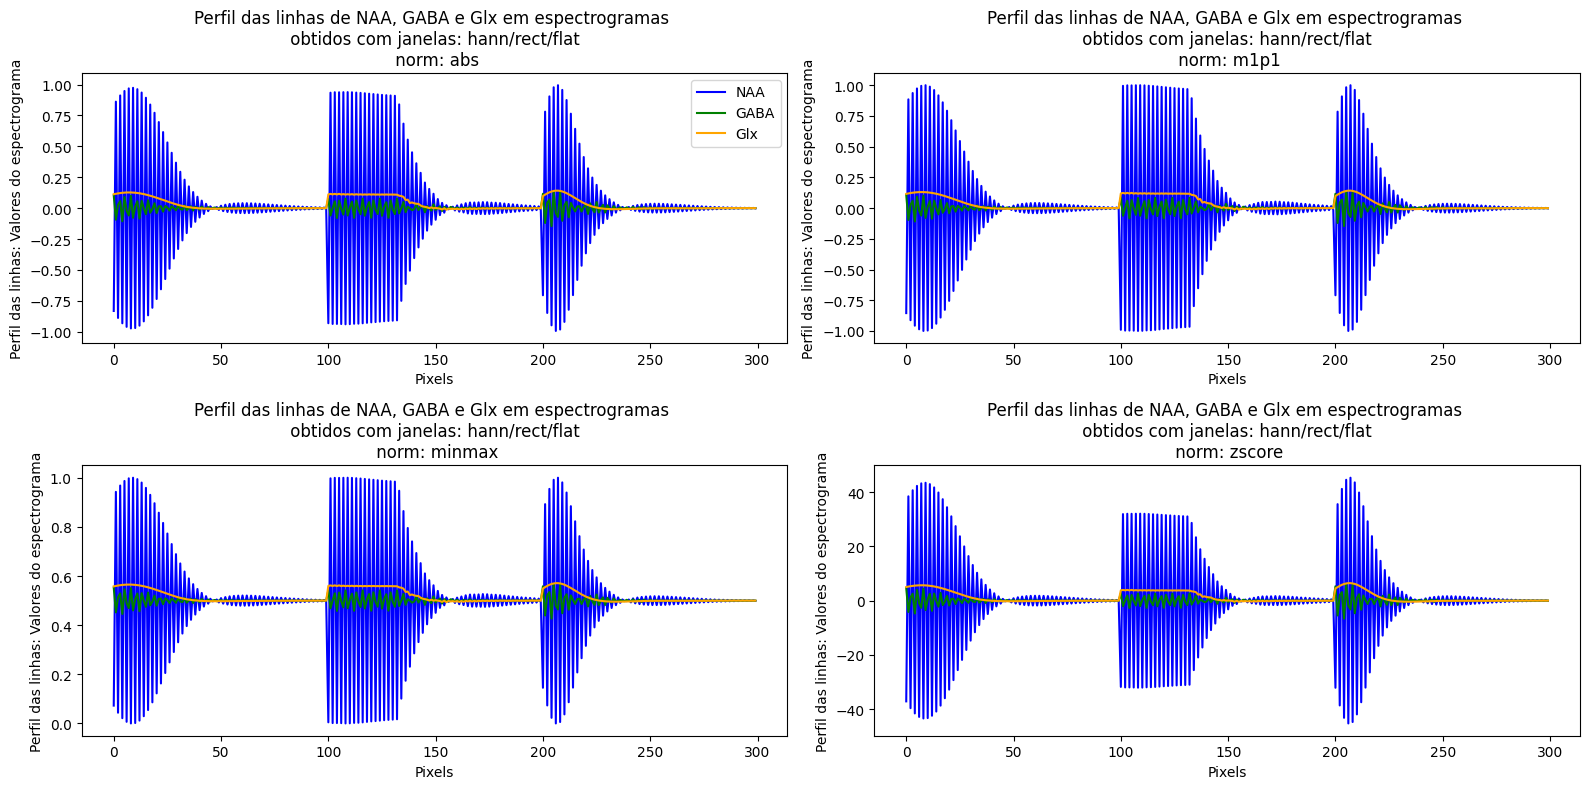

In [22]:
fig,ax = plt.subplots(2,2,figsize=(16,8))
for i in range(len(norm_)):
    ax.flat[i].plot(np.real(concat_by_norm_gt['norm_'+norm_[i]][idx_freq_NAA[i][0],:]),color='b',label='NAA')
    ax.flat[i].plot(np.real(concat_by_norm_gt['norm_'+norm_[i]][idx_freq_Glx[i][0],:]),color='g',label='GABA')
    ax.flat[i].plot(np.real(concat_by_norm_gt['norm_'+norm_[i]][idx_freq_GABA[i][0],:]),color='orange',label='Glx')
    ax.flat[i].set_title('Perfil das linhas de NAA, GABA e Glx em espectrogramas \n obtidos com janelas: hann/rect/flat \n norm: '+norm_[i])
    ax.flat[i].set_xlabel('Pixels')
    ax.flat[i].set_ylabel('Perfil das linhas: Valores do espectrograma')
    if i == 0: 
        ax.flat[i].legend(loc='upper right')

plt.tight_layout()
if test_not_save == False:
    plt.savefig('./relatorio_imagens/imagens_wn/spgram_varying_wn_profile_lines.png')

### 2.4 Comprimento dos picos x win x norm

A janela rect tende a gerar picos mais compridos do que os demais, o que concorda com a impressão visual avaliada na Seção 2.1.

Já a janela flat, visualmente parece levar a picos mais curtos, tanto da observação do espectrograma quanto das máscaras de segmentação, no entanto, quantidativamente, para o pico de Glx isso não é observado. O que possívelmente indica uma dificuldade do algoritmo de segmentação do pico.

Não se nota diferenças quanto ao comprimento dos picos em função da janela.

In [23]:
segm_dict_gt = {}
segm_dict_ns = {}
for i in range(len(norm_)):
    if norm_[i] == 'minmax':
        aux_dict = {}
        aux_dict_ns = {}
        for j in range(len(window_)):
            aux_dict['window_'+win_name[j]] = [spgram_wn_gt['norm_'+norm_[i]]['window_'+win_name[j]][0]-0.5,spgram_wn_gt['norm_'+norm_[i]]['window_'+win_name[j]][1],spgram_wn_gt['norm_'+norm_[i]]['window_'+win_name[j]][2],spgram_wn_gt['norm_'+norm_[i]]['window_'+win_name[j]][3]]
            aux_dict_ns['window_'+win_name[j]] = [spgram_wn_ns['norm_'+norm_[i]]['window_'+win_name[j]][0]-0.5,spgram_wn_ns['norm_'+norm_[i]]['window_'+win_name[j]][1],spgram_wn_ns['norm_'+norm_[i]]['window_'+win_name[j]][2],spgram_wn_ns['norm_'+norm_[i]]['window_'+win_name[j]][3]]
        segm_dict_gt['norm_'+norm_[i]] = funcstud.segment_relevant_peaks_dict(spgram_dict=aux_dict,idx_list_1ppm=idx_freq_1ppm[i],idx_list_4ppm=idx_freq_4ppm[i],idx_list_GABA=idx_freq_GABA[i],idx_list_NAA=idx_freq_NAA[i],idx_list_Glx=idx_freq_Glx[i],idx_time_list_0d4=idx_time_0d4[i],idx_peaks_regions_limits_dict=idx_fwhm_real_gt['norm_'+norm_[i]])
        segm_dict_ns['norm_'+norm_[i]] = funcstud.segment_relevant_peaks_dict(spgram_dict=aux_dict_ns,idx_list_1ppm=idx_freq_1ppm[i],idx_list_4ppm=idx_freq_4ppm[i],idx_list_GABA=idx_freq_GABA[i],idx_list_NAA=idx_freq_NAA[i],idx_list_Glx=idx_freq_Glx[i],idx_time_list_0d4=idx_time_0d4[i],idx_peaks_regions_limits_dict=idx_fwhm_real_ns['norm_'+norm_[i]])
    else: 
        segm_dict_gt['norm_'+norm_[i]] = funcstud.segment_relevant_peaks_dict(spgram_dict=spgram_wn_gt['norm_'+norm_[i]],idx_list_1ppm=idx_freq_1ppm[i],idx_list_4ppm=idx_freq_4ppm[i],idx_list_GABA=idx_freq_GABA[i],idx_list_NAA=idx_freq_NAA[i],idx_list_Glx=idx_freq_Glx[i],idx_time_list_0d4=idx_time_0d4[i],idx_peaks_regions_limits_dict=idx_fwhm_real_gt['norm_'+norm_[i]])
        segm_dict_ns['norm_'+norm_[i]] = funcstud.segment_relevant_peaks_dict(spgram_dict=spgram_wn_ns['norm_'+norm_[i]],idx_list_1ppm=idx_freq_1ppm[i],idx_list_4ppm=idx_freq_4ppm[i],idx_list_GABA=idx_freq_GABA[i],idx_list_NAA=idx_freq_NAA[i],idx_list_Glx=idx_freq_Glx[i],idx_time_list_0d4=idx_time_0d4[i],idx_peaks_regions_limits_dict=idx_fwhm_real_ns['norm_'+norm_[i]])

In [24]:
concat_abs_aux = np.zeros((100,300))
concat_m1p1_aux = np.zeros((100,300))
concat_minmax_aux = np.zeros((100,300))
concat_zscore_aux = np.zeros((100,300))
for i in range(3):
    concat_abs_aux[:,i*100:(i+1)*100] = segm_dict_gt['norm_abs']['window_'+win_name[i]][0,:,:100]*np.real(spgram_wn_gt['norm_abs']['window_'+win_name[0]][0][0,idx_freq_1ppm[0][i]:idx_freq_4ppm[0][i]+1,:idx_time_0d4[0][i]])
    concat_m1p1_aux[:,i*100:(i+1)*100] = segm_dict_gt['norm_m1p1']['window_'+win_name[i]][0,:,:100]*np.real(spgram_wn_gt['norm_m1p1']['window_'+win_name[0]][0][0,idx_freq_1ppm[1][i]:idx_freq_4ppm[1][i]+1,:idx_time_0d4[1][i]])
    concat_minmax_aux[:,i*100:(i+1)*100] = segm_dict_gt['norm_minmax']['window_'+win_name[i]][0,:,:100]*np.real(spgram_wn_gt['norm_minmax']['window_'+win_name[0]][0][0,idx_freq_1ppm[2][i]:idx_freq_4ppm[2][i]+1,:idx_time_0d4[2][i]])
    concat_zscore_aux[:,i*100:(i+1)*100] = segm_dict_gt['norm_zscore']['window_'+win_name[i]][0,:,:100]*np.real(spgram_wn_gt['norm_zscore']['window_'+win_name[0]][0][0,idx_freq_1ppm[3][i]:idx_freq_4ppm[3][i]+1,:idx_time_0d4[3][i]])

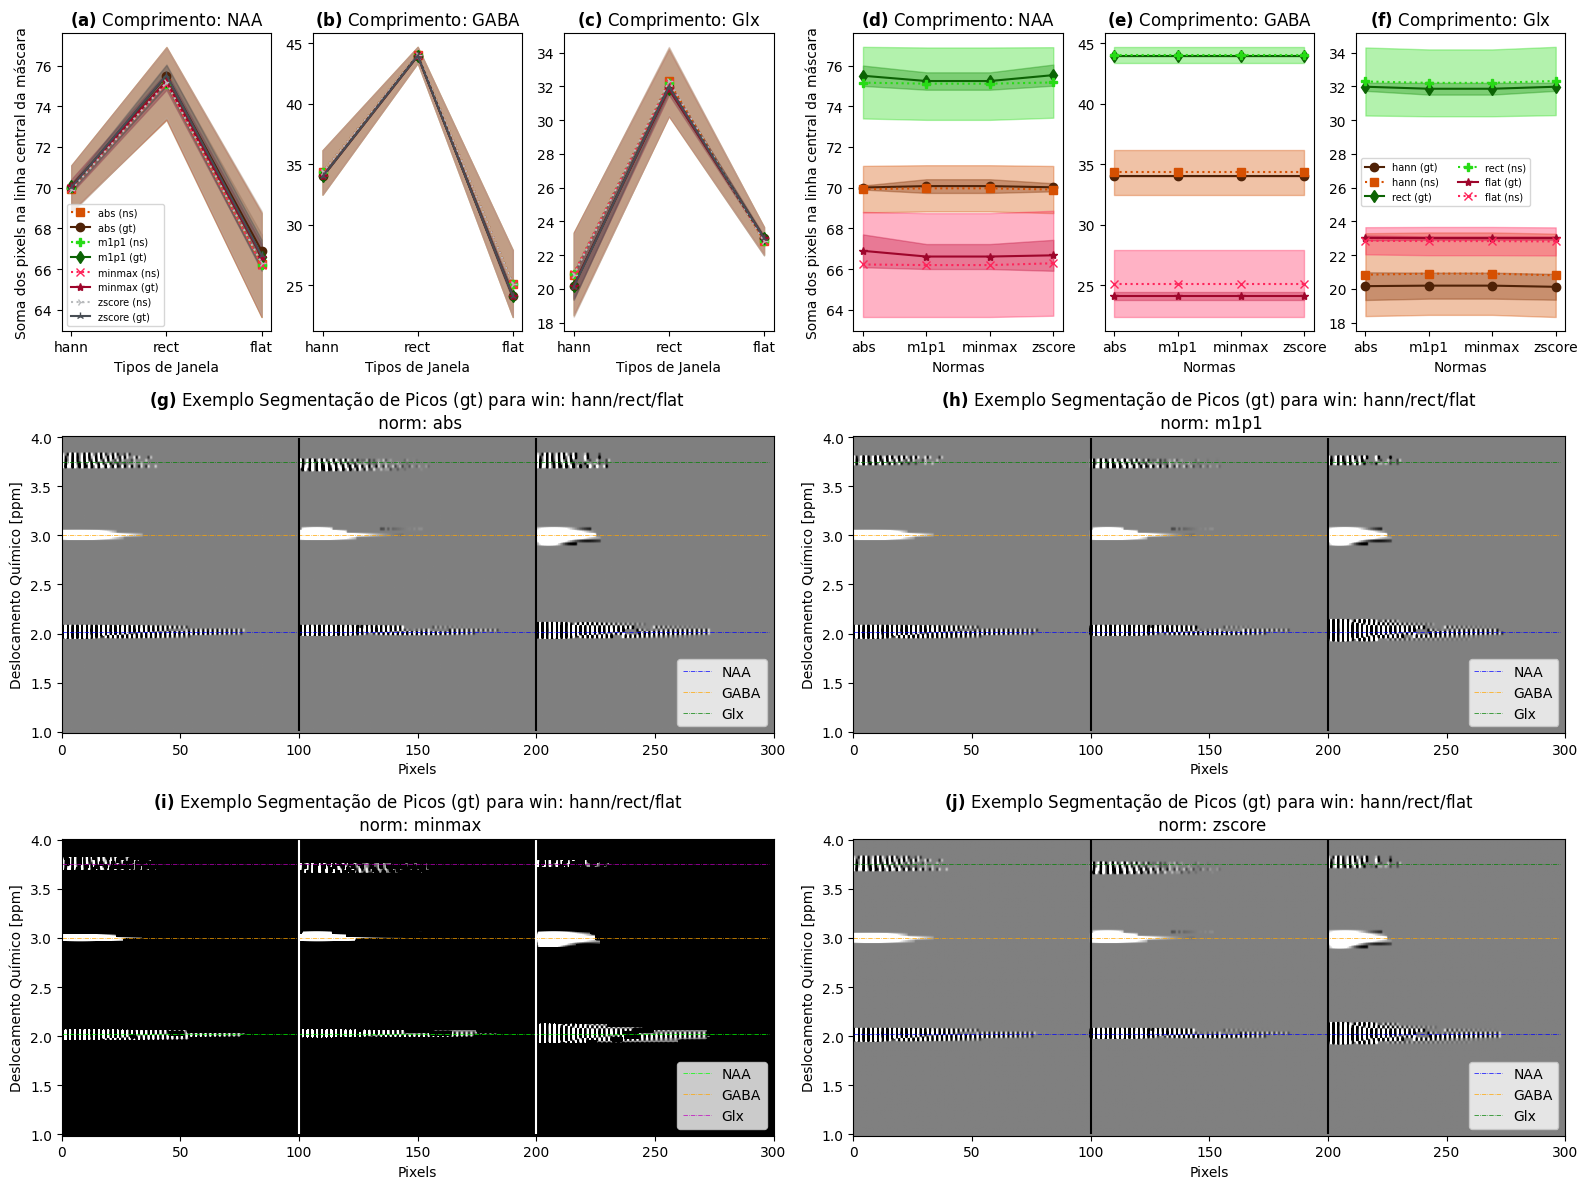

In [26]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(16, 12))
outer_grid = fig.add_gridspec(3, 2)
ax1 = outer_grid[0, 0].subgridspec(1,3, wspace=0.2, hspace=0.1)
ax1_in = ax1.subplots() 
ax2 = outer_grid[0, 1].subgridspec(1,3, wspace=0.2, hspace=0.1)
ax2_in = ax2.subplots() 
ax3 = outer_grid[1, 0].subgridspec(1,1).subplots()
ax4 = outer_grid[1, 1].subgridspec(1,1).subplots()
ax5 = outer_grid[2, 0].subgridspec(1,1).subplots() 
ax6 = outer_grid[2, 1].subgridspec(1,1).subplots()

marker_list = ['o','d','*','2','s','P','x','4']
color_list = ['#4f2207','#0c6304','#9e052b','#474d54','#d65002','#27db16','#ff245a','#b9bbbd']
label_list = ['NAA','GABA','Glx']
for k in range(3):
    for i in range(len(norm_)):
        ax1_in[k].plot(win_name,ns_metrics['sum_segment']['norm_'+norm_[i]][label_list[k]]['mean'],color=color_list[i+4],marker=marker_list[i+4],label=norm_[i]+' (ns)', linestyle='dotted')
        ax1_in[k].fill_between(win_name,np.array(ns_metrics['sum_segment']['norm_'+norm_[i]][label_list[k]]['mean']) - np.array(ns_metrics['sum_segment']['norm_'+norm_[i]][label_list[k]]['std']), 
                np.array(ns_metrics['sum_segment']['norm_'+norm_[i]][label_list[k]]['mean']) + np.array(ns_metrics['sum_segment']['norm_'+norm_[i]][label_list[k]]['std']), alpha=0.35, color=color_list[i+4])
        ax1_in[k].plot(win_name,gt_metrics['sum_segment']['norm_'+norm_[i]][label_list[k]]['mean'],color=color_list[i],marker=marker_list[i],label=norm_[i]+' (gt)')
        ax1_in[k].fill_between(win_name,np.array(gt_metrics['sum_segment']['norm_'+norm_[i]][label_list[k]]['mean']) - np.array(gt_metrics['sum_segment']['norm_'+norm_[i]][label_list[k]]['std']), 
                np.array(gt_metrics['sum_segment']['norm_'+norm_[i]][label_list[k]]['mean']) + np.array(gt_metrics['sum_segment']['norm_'+norm_[i]][label_list[k]]['std']), alpha=0.35, color=color_list[i])
        ax1_in[k].set_xlabel('Tipos de Janela')
        if k == 0:
            ax1_in[k].set_ylabel('Soma dos pixels na linha central da máscara')
    for j in range(len(win_name)):
        aux = []
        aux_std = []
        aux_ns = []
        aux_ns_std = []
        for i in range(len(norm_)):
            aux.append(gt_metrics['sum_segment']['norm_'+norm_[i]][label_list[k]]['mean'][j])
            aux_std.append(gt_metrics['sum_segment']['norm_'+norm_[i]][label_list[k]]['std'][j])
            aux_ns.append(ns_metrics['sum_segment']['norm_'+norm_[i]][label_list[k]]['mean'][j])
            aux_ns_std.append(ns_metrics['sum_segment']['norm_'+norm_[i]][label_list[k]]['std'][j])

        ax2_in[k].plot(norm_,aux,color=color_list[j],marker=marker_list[j],label=win_name[j]+' (gt)')
        ax2_in[k].fill_between(norm_,np.array(aux) - np.array(aux_std), 
                    np.array(aux) + np.array(aux_std), alpha=0.35, color=color_list[j])
        ax2_in[k].plot(norm_,aux_ns,color=color_list[j+4],marker=marker_list[j+4], linestyle='dotted', label=win_name[j]+' (ns)')
        ax2_in[k].fill_between(norm_,np.array(aux_ns) - np.array(aux_ns_std), 
                    np.array(aux_ns) + np.array(aux_ns_std), alpha=0.35, color=color_list[j+4])
        ax2_in[k].set_xlabel('Normas')
        if k==0:
            ax2_in[k].set_ylabel('Soma dos pixels na linha central da máscara')

ax3.imshow(concat_abs_aux,cmap='gray',aspect='auto',origin='lower',
                         vmin=-0.04,vmax=0.04,
                         extent=(0, concat_abs_aux.shape[-1],
                                 np.flip(spgram_wn_gt['norm_'+norm_[0]]['window_'+win_name[0]][2])[idx_freq_1ppm[0][0]],
                                 np.flip(spgram_wn_gt['norm_'+norm_[0]]['window_'+win_name[0]][2])[idx_freq_4ppm[0][0]]))
ax4.imshow(concat_m1p1_aux,cmap='gray',aspect='auto',origin='lower',
                         vmin=-0.04,vmax=0.04,
                         extent=(0, concat_abs_aux.shape[-1],
                                 np.flip(spgram_wn_gt['norm_'+norm_[0]]['window_'+win_name[0]][2])[idx_freq_1ppm[0][0]],
                                 np.flip(spgram_wn_gt['norm_'+norm_[0]]['window_'+win_name[0]][2])[idx_freq_4ppm[0][0]]))
ax5.imshow(concat_minmax_aux,cmap='gray',aspect='auto',origin='lower',
                         vmin=0.48,vmax=0.52,
                         extent=(0, concat_abs_aux.shape[-1],
                                 np.flip(spgram_wn_gt['norm_'+norm_[0]]['window_'+win_name[0]][2])[idx_freq_1ppm[0][0]],
                                 np.flip(spgram_wn_gt['norm_'+norm_[0]]['window_'+win_name[0]][2])[idx_freq_4ppm[0][0]]))
ax6.imshow(concat_zscore_aux,cmap='gray',aspect='auto',origin='lower',
                         vmin=-2,vmax=2,
                         extent=(0, concat_abs_aux.shape[-1],
                                 np.flip(spgram_wn_gt['norm_'+norm_[0]]['window_'+win_name[0]][2])[idx_freq_1ppm[0][0]],
                                 np.flip(spgram_wn_gt['norm_'+norm_[0]]['window_'+win_name[0]][2])[idx_freq_4ppm[0][0]]))



ax1_in[0].legend(loc='lower left',fontsize=7)
ax2_in[-1].legend(loc='center left', ncols=2,fontsize=7)
ax1_in[0].set_title('$\mathbf{(a)}$ Comprimento: NAA')
ax1_in[1].set_title('$\mathbf{(b)}$ Comprimento: GABA')
ax1_in[2].set_title('$\mathbf{(c)}$ Comprimento: Glx')
ax2_in[0].set_title('$\mathbf{(d)}$ Comprimento: NAA')
ax2_in[1].set_title('$\mathbf{(e)}$ Comprimento: GABA')
ax2_in[2].set_title('$\mathbf{(f)}$ Comprimento: Glx')
ax3.set_ylabel('Deslocamento Químico [ppm]')
ax3.set_xlabel('Pixels')
ax3.set_title('$\mathbf{(g)}$ Exemplo Segmentação de Picos (gt) para win: hann/rect/flat \n norm: '+norm_[0])
ax4.set_ylabel('Deslocamento Químico [ppm]')
ax4.set_xlabel('Pixels')
ax4.set_title('$\mathbf{(h)}$ Exemplo Segmentação de Picos (gt) para win: hann/rect/flat \n norm: '+norm_[1])
ax5.set_ylabel('Deslocamento Químico [ppm]')
ax5.set_xlabel('Pixels')
ax5.set_title('$\mathbf{(i)}$ Exemplo Segmentação de Picos (gt) para win: hann/rect/flat \n norm: '+norm_[2])
ax6.set_ylabel('Deslocamento Químico [ppm]')
ax6.set_xlabel('Pixels')
ax6.set_title('$\mathbf{(j)}$ Exemplo Segmentação de Picos (gt) para win: hann/rect/flat \n norm: '+norm_[3])

ax3.hlines(2.02,0.0005,298,color='b',linestyle='dashdot',linewidth=0.5,label='NAA')
ax3.hlines(3,0.0005,298,color='orange',linestyle='dashdot',linewidth=0.5,label='GABA')
ax3.hlines(3.75,0.0005,298,color='g',linestyle='dashdot',linewidth=0.5,label='Glx')
ax4.hlines(2.02,0.0005,298,color='b',linestyle='dashdot',linewidth=0.5,label='NAA')
ax4.hlines(3,0.0005,298,color='orange',linestyle='dashdot',linewidth=0.5,label='GABA')
ax4.hlines(3.75,0.0005,298,color='g',linestyle='dashdot',linewidth=0.5,label='Glx')
ax5.hlines(2.02,0.0005,298,color='lime',linestyle='dashdot',linewidth=0.5,label='NAA')
ax5.hlines(3,0.0005,298,color='orange',linestyle='dashdot',linewidth=0.5,label='GABA')
ax5.hlines(3.75,0.0005,298,color='m',linestyle='dashdot',linewidth=0.5,label='Glx')
ax6.hlines(2.02,0.0005,298,color='b',linestyle='dashdot',linewidth=0.5,label='NAA')
ax6.hlines(3,0.0005,298,color='orange',linestyle='dashdot',linewidth=0.5,label='GABA')
ax6.hlines(3.75,0.0005,298,color='g',linestyle='dashdot',linewidth=0.5,label='Glx')
ax3.vlines(100,1.005,3.995,color='black')
ax3.vlines(200,1.005,3.995,color='black')
ax4.vlines(100,1.005,3.995,color='black')
ax4.vlines(200,1.005,3.995,color='black')
ax5.vlines(100,1.005,3.995,color='white')
ax5.vlines(200,1.005,3.995,color='white')
ax6.vlines(100,1.005,3.995,color='black')
ax6.vlines(200,1.005,3.995,color='black')
ax3.legend(loc='lower right')
ax4.legend(loc='lower right')
ax5.legend(loc='lower right')
ax6.legend(loc='lower right')

plt.tight_layout()
if test_not_save == False:
    plt.savefig('./relatorio_imagens/imagens_wn/spgram_varying_wn_sumsegmentation.png')

### 2.5 O padrão de listras das imagens muda com win e norm?

Para essa análise, além da observação dos espectrogramas na Seção 2.1, também considera-se a métrica ZCR e espectrogramas gerados com hop = 20, pois as listras de NAA e Glx são mais grossas para esse valor, e assim, mais visíveis.

Visualmente pelos espectrogramas da Seção 2.1, não parece haver mudança com a norma, e pelas métricas, isso também não é observado. Como as janelas mudam o formato dos picos, há dúvida se isso provoca mudanças no padrão de listras.

Pela métrica ZCR, a janela rect tende a levar a um ZCR mais elevado, isso pode ser consequência da janela aumentar o comprimento dos picos, bem como pode ser derivado da presença de artefatos ao redor dos picos.

Para NAA e GABA, as janelas hann e flat levam a ZCR similares. Novamente, Glx constitui uma exceção. Da observação visual de espectrogramas obtidos com hop = 20, não parece haver diferença na quantidade de listras para os picos principais entre espectrogramas obtidos com janela falt e hann, o que sugere que a influência da janela nas listras dos picos é limitada, e possivelmente associada a extensão do pico.

Observação: nota-se que para os espectrogramas obtidos com hop = 20, a janela hann leva a espectrogramas com um valor médio mais elevado para as normas m1p1 e minmax (fundo cinza mais esbranquiçado), e a janela flat a espectrograma com um valor médio menor para as mesmas normas (fundo se torna preto na janela de constraste considerada). Outra sugestão de efeitos combinados de win-norm.

In [28]:
#to help with visualization: also let's visualize spectrograms with hop = 20
mfft_ = 512
window_ = [hann(mfft_,sym=True),boxcar(mfft_,sym=True),flattop(mfft_,sym=True)]
win_name =['hann','rect','flat']
hop_alt = 20
norm_ = ['abs','m1p1','minmax','zscore']
spgram_wn_gt_aux= {}
for i in range(len(norm_)):
    spgram_wn_gt_aux['norm_'+norm_[i]] = {}
for i in range(len(norm_)):
    for j in range(len(window_)):
        spgram_gt, freq_spect, ppm_spect, t_spect = utils.get_normalized_spectrogram(fids=gt_fids[:,:,1]-gt_fids[:,:,0],bandwidth=bandwidth,window=window_[j],mfft=mfft_,hop=hop_alt,norm=norm_[i],correct_time=True,a=a,b=b)
        spgram_wn_gt_aux['norm_'+norm_[i]]['window_'+win_name[j]] = [spgram_gt, freq_spect, ppm_spect, t_spect]

In [29]:
idx_time_0d4_aux = []
for i in range(len(norm_)):
    list_of_t_spects_aux = []
    for j in range(len(window_)):
        list_of_t_spects_aux.append(spgram_wn_gt_aux['norm_'+norm_[i]]['window_'+win_name[j]][-1])
    idx_time_0d4_aux.append(utils.give_idx_time_point_for_different_time_arrays(list_time_arrays=list_of_t_spects_aux,time_point=0.4))
concat_by_norm_gt_aux = {}
for i in range(len(norm_)):
    concat_by_norm_gt_aux['norm_'+norm_[i]] = utils.concatenate_generic(selected_keys=list(spgram_wn_gt_aux['norm_'+norm_[i]].keys()),spgram_dict=spgram_wn_gt_aux['norm_'+norm_[i]],list_time_idx=idx_time_0d4_aux[i],fid_idx_plot=0)

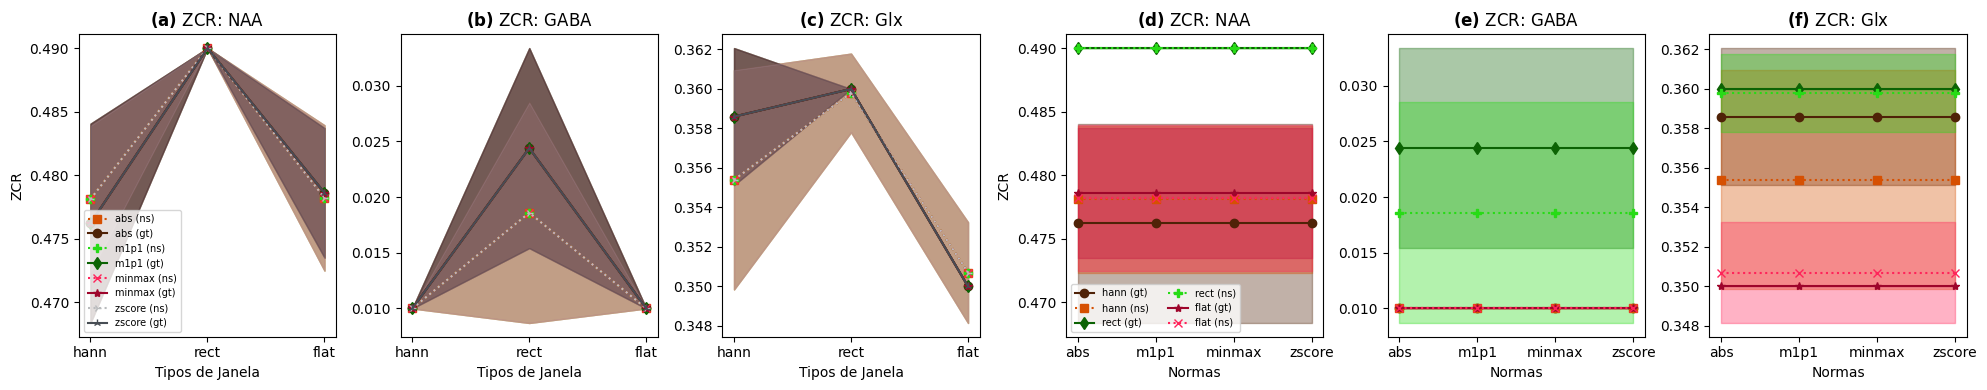

In [31]:
fig = plt.figure(figsize=(20, 4))
outer_grid = fig.add_gridspec(1, 2)
ax1 = outer_grid[0].subgridspec(1,3, wspace=0.25, hspace=0.1)
ax1_in = ax1.subplots()  
ax2 = outer_grid[1].subgridspec(1,3, wspace=0.25, hspace=0.1)
ax2_in = ax2.subplots()  


marker_list = ['o','d','*','2','s','P','x','4']
color_list = ['#4f2207','#0c6304','#9e052b','#474d54','#d65002','#27db16','#ff245a','#b9bbbd']
label_list = ['NAA','GABA','Glx']
for k in range(3):
    for i in range(len(norm_)):
        ax1_in[k].plot(win_name,ns_metrics['zcr_'][label_list[k]][i]['mean'],color=color_list[i+4],marker=marker_list[i+4],label=norm_[i]+' (ns)', linestyle='dotted')
        ax1_in[k].fill_between(win_name,np.array(ns_metrics['zcr_'][label_list[k]][i]['mean']) - np.array(ns_metrics['zcr_'][label_list[k]][i]['std']), 
                np.array(ns_metrics['zcr_'][label_list[k]][i]['mean']) + np.array(ns_metrics['zcr_'][label_list[k]][i]['std']), alpha=0.35, color=color_list[i+4])
        ax1_in[k].plot(win_name,gt_metrics['zcr_'][label_list[k]][i]['mean'],color=color_list[i],marker=marker_list[i],label=norm_[i]+' (gt)')
        ax1_in[k].fill_between(win_name,np.array(gt_metrics['zcr_'][label_list[k]][i]['mean']) - np.array(gt_metrics['zcr_'][label_list[k]][i]['std']), 
                np.array(gt_metrics['zcr_'][label_list[k]][i]['mean']) + np.array(gt_metrics['zcr_'][label_list[k]][i]['std']), alpha=0.35, color=color_list[i])
        ax1_in[k].set_xlabel('Tipos de Janela')
        if k == 0:
            ax1_in[k].set_ylabel('ZCR')
    for j in range(len(win_name)):
        aux = []
        aux_std = []
        aux_ns = []
        aux_ns_std = []
        for i in range(len(norm_)):
            aux.append(gt_metrics['zcr_'][label_list[k]][i]['mean'][j])
            aux_std.append(gt_metrics['zcr_'][label_list[k]][i]['std'][j])
            aux_ns.append(ns_metrics['zcr_'][label_list[k]][i]['mean'][j])
            aux_ns_std.append(ns_metrics['zcr_'][label_list[k]][i]['std'][j])

        ax2_in[k].plot(norm_,aux,color=color_list[j],marker=marker_list[j],label=win_name[j]+' (gt)')
        ax2_in[k].fill_between(norm_,np.array(aux) - np.array(aux_std), 
                    np.array(aux) + np.array(aux_std), alpha=0.35, color=color_list[j])
        ax2_in[k].plot(norm_,aux_ns,color=color_list[j+4],marker=marker_list[j+4], linestyle='dotted', label=win_name[j]+' (ns)')
        ax2_in[k].fill_between(norm_,np.array(aux_ns) - np.array(aux_ns_std), 
                    np.array(aux_ns) + np.array(aux_ns_std), alpha=0.35, color=color_list[j+4])
        ax2_in[k].set_xlabel('Normas')
        if k==0:
            ax2_in[k].set_ylabel('ZCR')

ax1_in[0].legend(loc='lower left',fontsize=7)
ax2_in[0].legend(loc='best', ncols=2,fontsize=7)
ax1_in[0].set_title('$\mathbf{(a)}$ ZCR: NAA')
ax1_in[1].set_title('$\mathbf{(b)}$ ZCR: GABA')
ax1_in[2].set_title('$\mathbf{(c)}$ ZCR: Glx')
ax2_in[0].set_title('$\mathbf{(d)}$ ZCR: NAA')
ax2_in[1].set_title('$\mathbf{(e)}$ ZCR: GABA')
ax2_in[2].set_title('$\mathbf{(f)}$ ZCR: Glx')

plt.tight_layout()
if test_not_save == False:
    plt.savefig('./relatorio_imagens/imagens_wn/spgram_varying_wn_zcr.png')

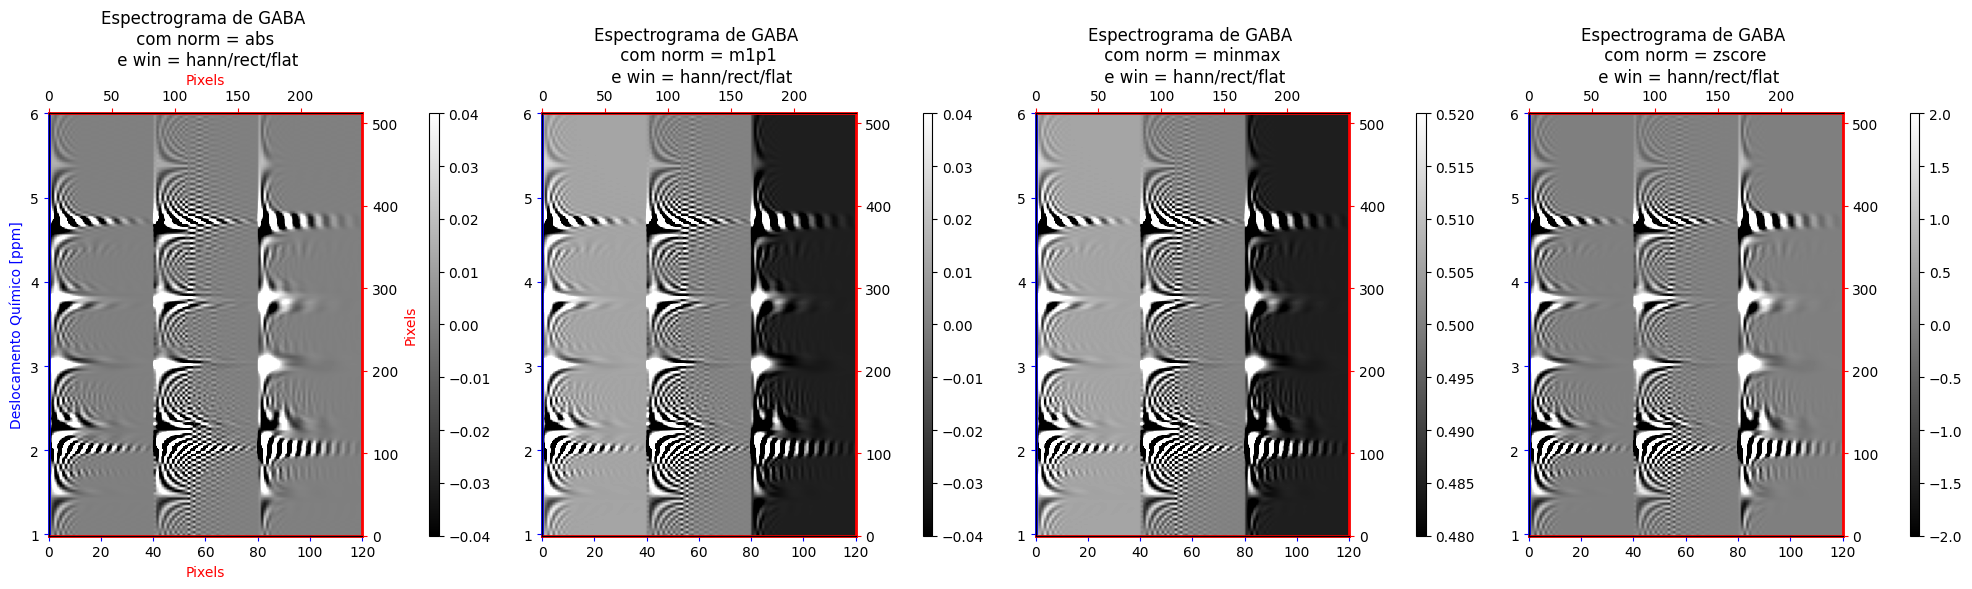

In [30]:
fig,ax = plt.subplots(1,4,figsize=(20,6))

for i in range(len(norm_)):
    if norm_[i] == 'abs' or norm_[i] == 'm1p1':
        vmin_ = -0.04
        vmax_ = 0.04
    elif norm_[i] == 'minmax':
        vmin_ = 0.48
        vmax_ = 0.52
    else:
        vmin_ = -2
        vmax_ = 2
    im = ax.flat[i].imshow(np.real(concat_by_norm_gt_aux['norm_'+norm_[i]][idx_freq_1ppm[0][0]:idx_freq_6ppm[0][0],:]), origin='lower', aspect='auto',cmap='gray',vmin=vmin_,vmax=vmax_,
              extent = (0,concat_by_norm_gt_aux['norm_'+norm_[i]].shape[-1],np.flip(spgram_wn_gt['norm_'+norm_[i]]['window_'+win_name[0]][2])[idx_freq_1ppm[i][0]],np.flip(spgram_wn_gt['norm_'+norm_[0]]['window_'+win_name[0]][2])[idx_freq_6ppm[i][0]]))
    fig.colorbar(im, ax=ax.flat[i], pad = 0.15, aspect=45)

for i in range(4):
    par1 = ax.flat[i].twiny()
    par2 = ax.flat[i].twinx()
    if i < 4:
        ax.flat[i].set_title('Espectrograma de GABA \n com norm = '+norm_[i]+' \n e win = hann/rect/flat')
    if  i == 0:
        ax.flat[i].set_xlabel('Pixels')
        ax.flat[i].set_ylabel('Deslocamento Químico [ppm]')
        ax.flat[i].xaxis.label.set_color('r')
        ax.flat[i].yaxis.label.set_color('b')
    ax.flat[i].spines['left'].set_visible(True)
    ax.flat[i].spines['bottom'].set_visible(True)
    ax.flat[i].spines['left'].set_color('b')
    ax.flat[i].spines['bottom'].set_color('r')
    ax.flat[i].spines['left'].set_linewidth(2)
    ax.flat[i].spines['bottom'].set_linewidth(2)
    par1.spines['top'].set_position(('axes', 1))
    par2.spines['right'].set_position(('axes', 1))
    par1.set_xlim(0,spgram_wn_gt['norm_'+norm_[0]]['window_'+win_name[0]][0].shape[2])
    par2.set_ylim(0,spgram_wn_gt['norm_'+norm_[0]]['window_'+win_name[0]][0].shape[1])

    if i == 0:
        par1.set_xlabel("Pixels")
        par2.set_ylabel("Pixels")
        par1.xaxis.label.set_color('r')
        par2.yaxis.label.set_color('r')
    par1.spines['top'].set_visible(True)
    par2.spines['right'].set_visible(True)
    par2.spines['right'].set_color('r')
    par1.spines['top'].set_color('r')
    par2.spines['right'].set_linewidth(2)
    par1.spines['top'].set_linewidth(2)
    ax.flat[i].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, labeltop=False,color='b')
    par1.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True,color ='r')
    ax.flat[i].tick_params(axis='y', which='both', left=True, right=False, labelleft=True, labelright=False,color='b')
    par2.tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True,color='r')


plt.tight_layout()
if test_not_save == False:
    plt.savefig('./relatorio_imagens/imagens_wn/spgram_varying_wn_norms_and_winds_ns_gt_hop20.png')

## 3.0 Análise das Variações Estatísticas Provocadas por win e norm 

### 3.1 Características Globais

Apesar das diferenças observadas, estatisticamente, as distribuições dos espectrogramas obtidos com cada norma são, no geral, bem parecidas. Obviamente, a média e mediana da norma minmax é em torno de 0.5, enquanto as demais se concentram em torno de zero, e o desvio-padrão da norma zscore é bem superior aos demais devido a maior amplitude entre os valores (-40 a 40), enquanto os demais estão limitados entre -1 e 1 ou 0 e 1 (minmax). Porém, em termos de formato - simetria e presença de outliers - todas as normas são muito similares, vide as medições de kurtosis e skewness, e a visualização dos histogramas dos espectrogramas.

Nota-se que a janela rect leva a um maior skewness e menor kurtosis. Da observação dos histogramas, nota-se que tal janela também leva a um maior desvio-padrão - largura do pico central é maior -, com exceção quando combinada a norma zscore.

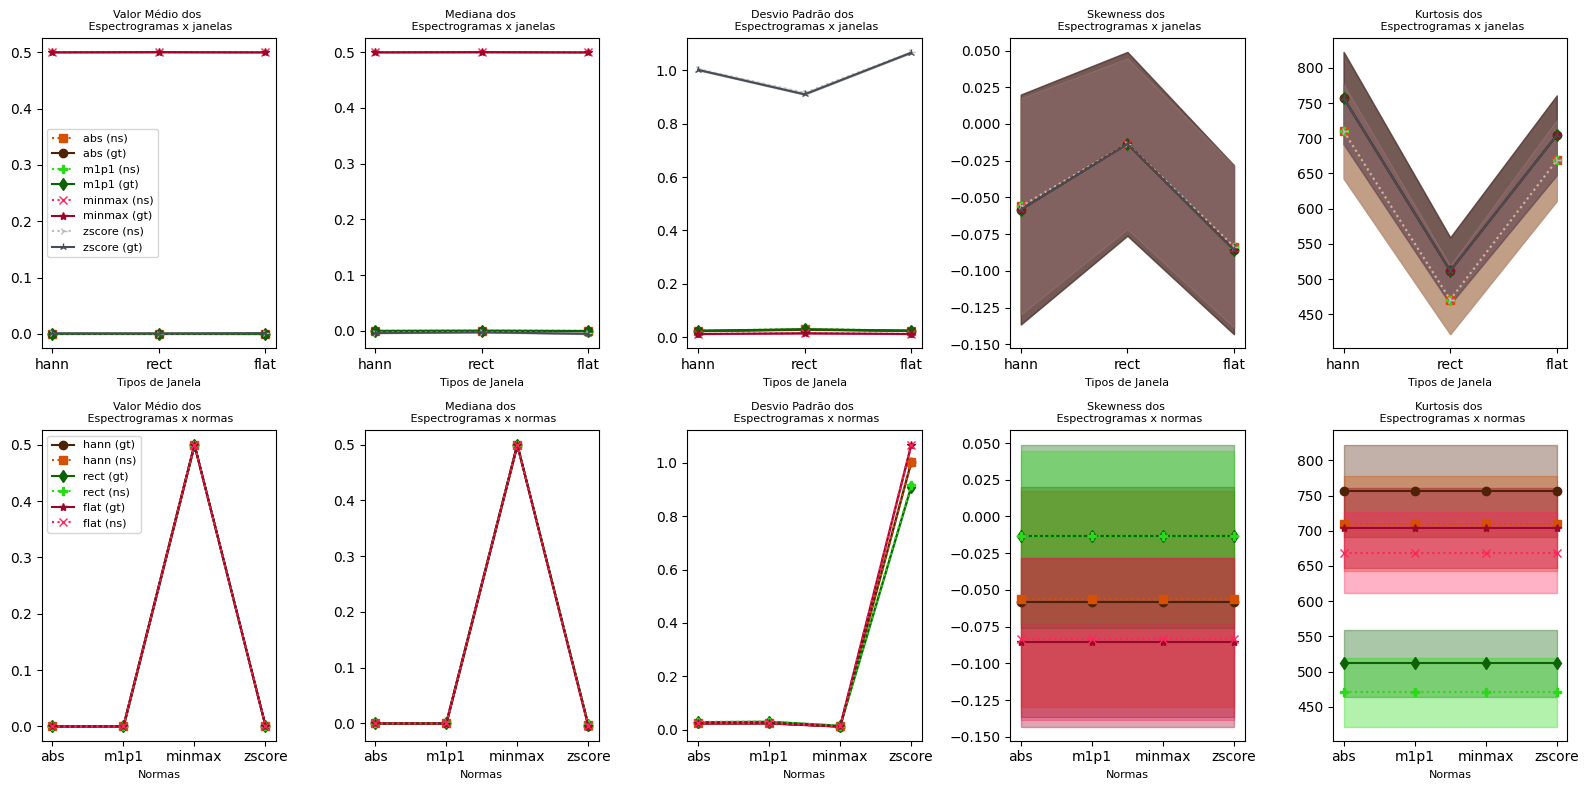

In [32]:
fig, ax = plt.subplots(2,5, figsize=(16,8))


marker_list = ['o','d','*','2','s','P','x','4']
color_list = ['#4f2207','#0c6304','#9e052b','#474d54','#d65002','#27db16','#ff245a','#b9bbbd']
metric_list = ['mean','median','std','skewness','kurtosis']
for k in range(len(metric_list)):
    for i in range(len(norm_)):
        ax.flat[k].plot(win_name,ns_metrics['stats_global']['norm_'+norm_[i]][metric_list[k]]['mean'],color=color_list[i+4],marker=marker_list[i+4],label=norm_[i]+' (ns)', linestyle='dotted')
        ax.flat[k].fill_between(win_name,np.array(ns_metrics['stats_global']['norm_'+norm_[i]][metric_list[k]]['mean']) - np.array(ns_metrics['stats_global']['norm_'+norm_[i]][metric_list[k]]['std']), 
                np.array(ns_metrics['stats_global']['norm_'+norm_[i]][metric_list[k]]['mean']) + np.array(ns_metrics['stats_global']['norm_'+norm_[i]][metric_list[k]]['std']), alpha=0.35, color=color_list[i+4])
        ax.flat[k].plot(win_name,gt_metrics['stats_global']['norm_'+norm_[i]][metric_list[k]]['mean'],color=color_list[i],marker=marker_list[i],label=norm_[i]+' (gt)')
        ax.flat[k].fill_between(win_name,np.array(gt_metrics['stats_global']['norm_'+norm_[i]][metric_list[k]]['mean']) - np.array(gt_metrics['stats_global']['norm_'+norm_[i]][metric_list[k]]['std']), 
                np.array(gt_metrics['stats_global']['norm_'+norm_[i]][metric_list[k]]['mean']) + np.array(gt_metrics['stats_global']['norm_'+norm_[i]][metric_list[k]]['std']), alpha=0.35, color=color_list[i])
        ax.flat[k].set_xlabel('Tipos de Janela',fontsize=8)

    for j in range(len(win_name)):
        aux = []
        aux_std = []
        aux_ns = []
        aux_ns_std = []
        for i in range(len(norm_)):
            aux.append(gt_metrics['stats_global']['norm_'+norm_[i]][metric_list[k]]['mean'][j])
            aux_std.append(gt_metrics['stats_global']['norm_'+norm_[i]][metric_list[k]]['std'][j])
            aux_ns.append(ns_metrics['stats_global']['norm_'+norm_[i]][metric_list[k]]['mean'][j])
            aux_ns_std.append(ns_metrics['stats_global']['norm_'+norm_[i]][metric_list[k]]['std'][j])

        ax.flat[k+5].plot(norm_,aux,color=color_list[j],marker=marker_list[j],label=win_name[j]+' (gt)')
        ax.flat[k+5].fill_between(norm_,np.array(aux) - np.array(aux_std), 
                    np.array(aux) + np.array(aux_std), alpha=0.35, color=color_list[j])
        ax.flat[k+5].plot(norm_,aux_ns,color=color_list[j+4],marker=marker_list[j+4], linestyle='dotted', label=win_name[j]+' (ns)')
        ax.flat[k+5].fill_between(norm_,np.array(aux_ns) - np.array(aux_ns_std), 
                    np.array(aux_ns) + np.array(aux_ns_std), alpha=0.35, color=color_list[j+4])
        ax.flat[k+5].set_xlabel('Normas',fontsize=8)

ax.flat[0].set_title('Valor Médio dos \n Espectrogramas x janelas',fontsize=8)
ax.flat[1].set_title('Mediana dos \n Espectrogramas x janelas',fontsize=8)
ax.flat[2].set_title('Desvio Padrão dos \n Espectrogramas x janelas',fontsize=8)
ax.flat[3].set_title('Skewness dos \n Espectrogramas x janelas',fontsize=8)
ax.flat[4].set_title('Kurtosis dos \n Espectrogramas x janelas',fontsize=8)

ax.flat[0+5].set_title('Valor Médio dos \n Espectrogramas x normas',fontsize=8)
ax.flat[1+5].set_title('Mediana dos \n Espectrogramas x normas',fontsize=8)
ax.flat[2+5].set_title('Desvio Padrão dos \n Espectrogramas x normas',fontsize=8)
ax.flat[3+5].set_title('Skewness dos \n Espectrogramas x normas',fontsize=8)
ax.flat[4+5].set_title('Kurtosis dos \n Espectrogramas x normas',fontsize=8)

ax.flat[0].legend(loc='center left',fontsize=8)
ax.flat[5].legend(loc='upper left',fontsize=8)

plt.tight_layout()
if test_not_save == False:
    plt.savefig('./relatorio_imagens/imagens_wn/spgram_varying_wn_global_stats.png')

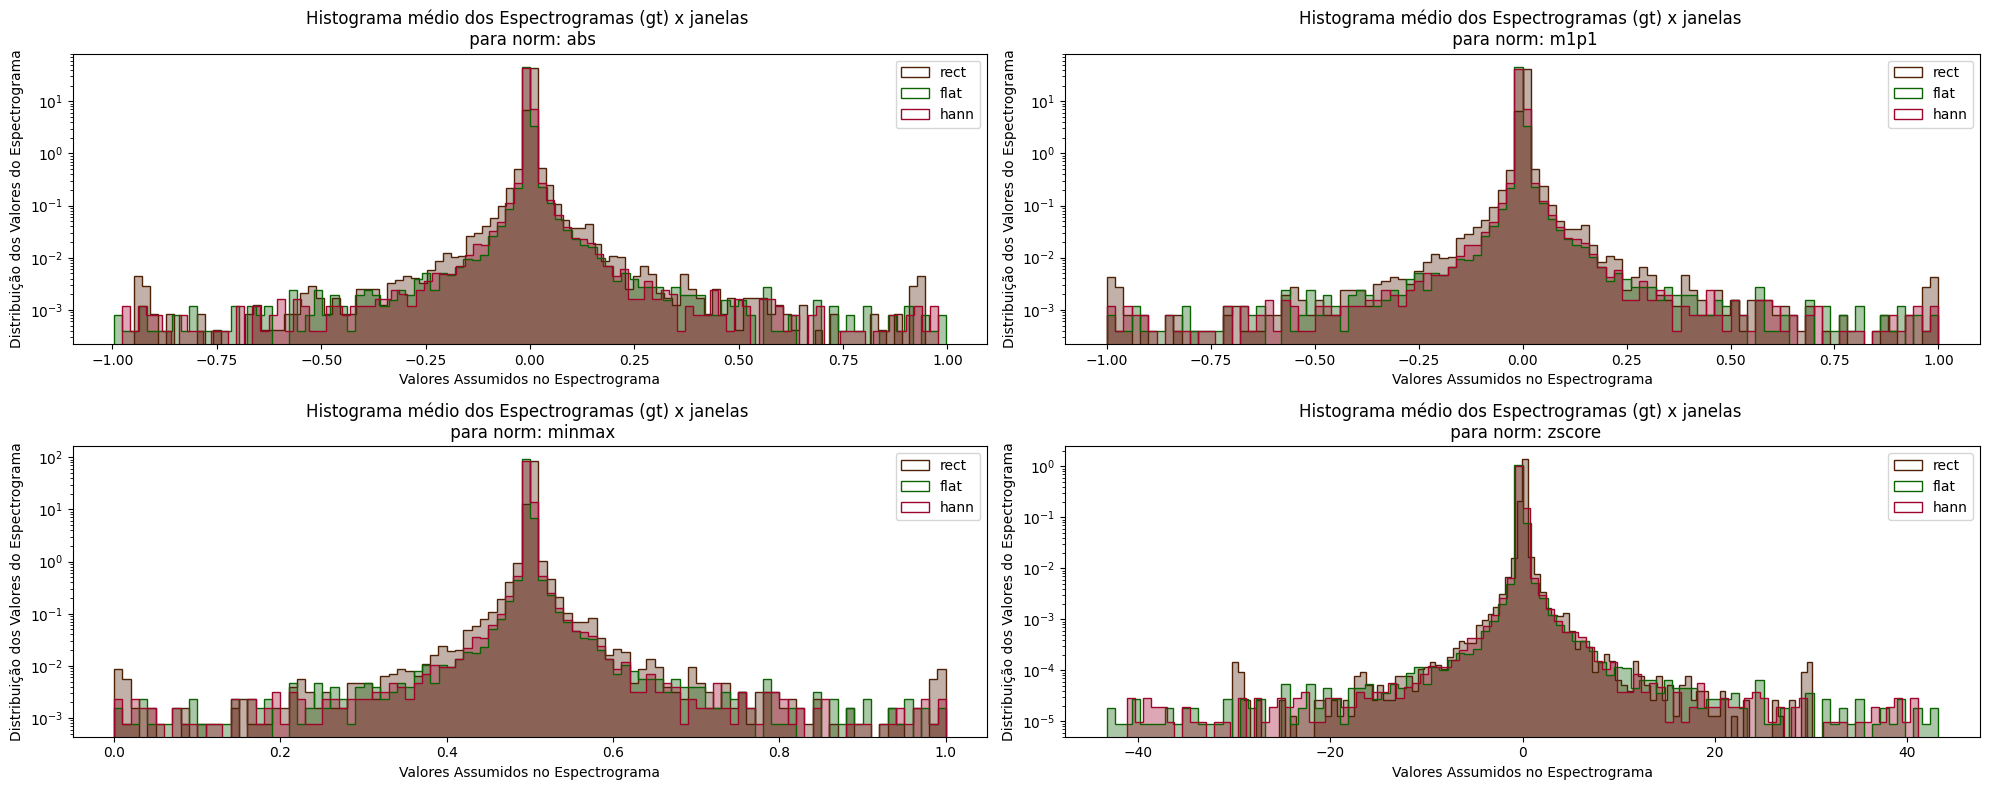

In [33]:
fig,ax = plt.subplots(2,2,figsize=(20,8))
color_list = ['#4f2207','#0c6304','#9e052b']
for i in range(len(norm_)):
    im=ax.flat[i].hist(np.mean(np.real(spgram_wn_gt['norm_'+norm_[i]]['window_'+win_name[1]][0]),axis=0).flatten(),100,histtype='step',density = True,color=color_list[0],label=win_name[1])
    im=ax.flat[i].hist(np.mean(np.real(spgram_wn_gt['norm_'+norm_[i]]['window_'+win_name[2]][0]),axis=0).flatten(),100,histtype='step',density = True,color=color_list[1],label=win_name[2])
    im=ax.flat[i].hist(np.mean(np.real(spgram_wn_gt['norm_'+norm_[i]]['window_'+win_name[0]][0]),axis=0).flatten(),100,histtype='step',density = True,color=color_list[2],label=win_name[0])
    im=ax.flat[i].hist(np.mean(np.real(spgram_wn_gt['norm_'+norm_[i]]['window_'+win_name[1]][0]),axis=0).flatten(),100,density = True,alpha=0.35,color=color_list[0])
    im=ax.flat[i].hist(np.mean(np.real(spgram_wn_gt['norm_'+norm_[i]]['window_'+win_name[2]][0]),axis=0).flatten(),100,density = True,alpha=0.35,color=color_list[1])
    im=ax.flat[i].hist(np.mean(np.real(spgram_wn_gt['norm_'+norm_[i]]['window_'+win_name[0]][0]),axis=0).flatten(),100,density = True,alpha=0.35,color=color_list[2])
    ax.flat[i].legend(loc='upper right')
    ax.flat[i].set_title('Histograma médio dos Espectrogramas (gt) x janelas \n para norm: '+norm_[i])
    ax.flat[i].set_yscale('log')
    ax.flat[i].set_xlabel('Valores Assumidos no Espectrograma')
    ax.flat[i].set_ylabel('Distribuição dos Valores do Espectrograma')

plt.tight_layout()
if test_not_save == False:
    plt.savefig('./relatorio_imagens/imagens_wn/spgram_varying_wn_global_hist.png')

### 3.2 Características Regionais

Quando isola-se apenas a região de resíduos dos espectrogramas de sinais gt - ou região de ruído de sinais ns. Alguns efeitos pertencentes somente a essa região são ressaltados.

Nesse caso, para sinais gt, fica visível a diferença nas distribuições em função da combinação win-norm. Para m1p1 e minmax, a janela flat tende a gerar uma moda menor, e a janela rect, uma moda maior. Para a norma abs, as janelas geram distribuições com moda muito próximas. 

A presença de ruído, por alongar a amplitude dos valores considerados no fundo da imagem, torna esses efeitos menos perceptíveis. Quantitativamente, os valores médios das distribuições se tornam mais próximos entre as janelas para todas as normas, com exceção de zscore. Assim, esse efeito visual de maior proximidade entre os valores médios das distribuições pela adição de ruído se confirma na maior parte dos casos pela avaliação quantitativa.

Com a adição de ruído, fica evidente que rect gera distribuições mais largas em torno do centro considerando os dados da região do ruído.

In [34]:
concat_abs_aux_gt = np.zeros((512,3*249))
concat_m1p1_aux_gt = np.zeros((512,3*249))
concat_minmax_aux_gt = np.zeros((512,3*249))
concat_zscore_aux_gt = np.zeros((512,3*249))
concat_abs_aux_ns = np.zeros((512,3*249))
concat_m1p1_aux_ns = np.zeros((512,3*249))
concat_minmax_aux_ns = np.zeros((512,3*249))
concat_zscore_aux_ns = np.zeros((512,3*249))
for i in range(3):
    concat_abs_aux_gt[:,i*249:(i+1)*249] = np.abs(np.real(spgram_wn_gt['norm_abs']['window_'+win_name[i]][0][0,:,:])) < 0.001
    concat_m1p1_aux_gt[:,i*249:(i+1)*249] = np.abs(np.real(spgram_wn_gt['norm_m1p1']['window_'+win_name[i]][0][0,:,:])) < 0.001
    concat_minmax_aux_gt[:,i*249:(i+1)*249] = np.abs(np.real(spgram_wn_gt['norm_minmax']['window_'+win_name[i]][0][0,:,:])-0.5) < 0.0005
    concat_zscore_aux_gt[:,i*249:(i+1)*249] = np.abs(np.real(spgram_wn_gt['norm_zscore']['window_'+win_name[i]][0][0,:,:])) < 0.015
    concat_abs_aux_ns[:,i*249:(i+1)*249] = np.abs(np.real(spgram_wn_ns['norm_abs']['window_'+win_name[i]][0][0,:,:])) < 0.028
    concat_m1p1_aux_ns[:,i*249:(i+1)*249] = np.abs(np.real(spgram_wn_ns['norm_m1p1']['window_'+win_name[i]][0][0,:,:])) < 0.028
    concat_minmax_aux_ns[:,i*249:(i+1)*249] = np.abs(np.real(spgram_wn_ns['norm_minmax']['window_'+win_name[i]][0][0,:,:])-0.5) < 0.014
    concat_zscore_aux_ns[:,i*249:(i+1)*249] = np.abs(np.real(spgram_wn_ns['norm_zscore']['window_'+win_name[i]][0][0,:,:])) < 0.8

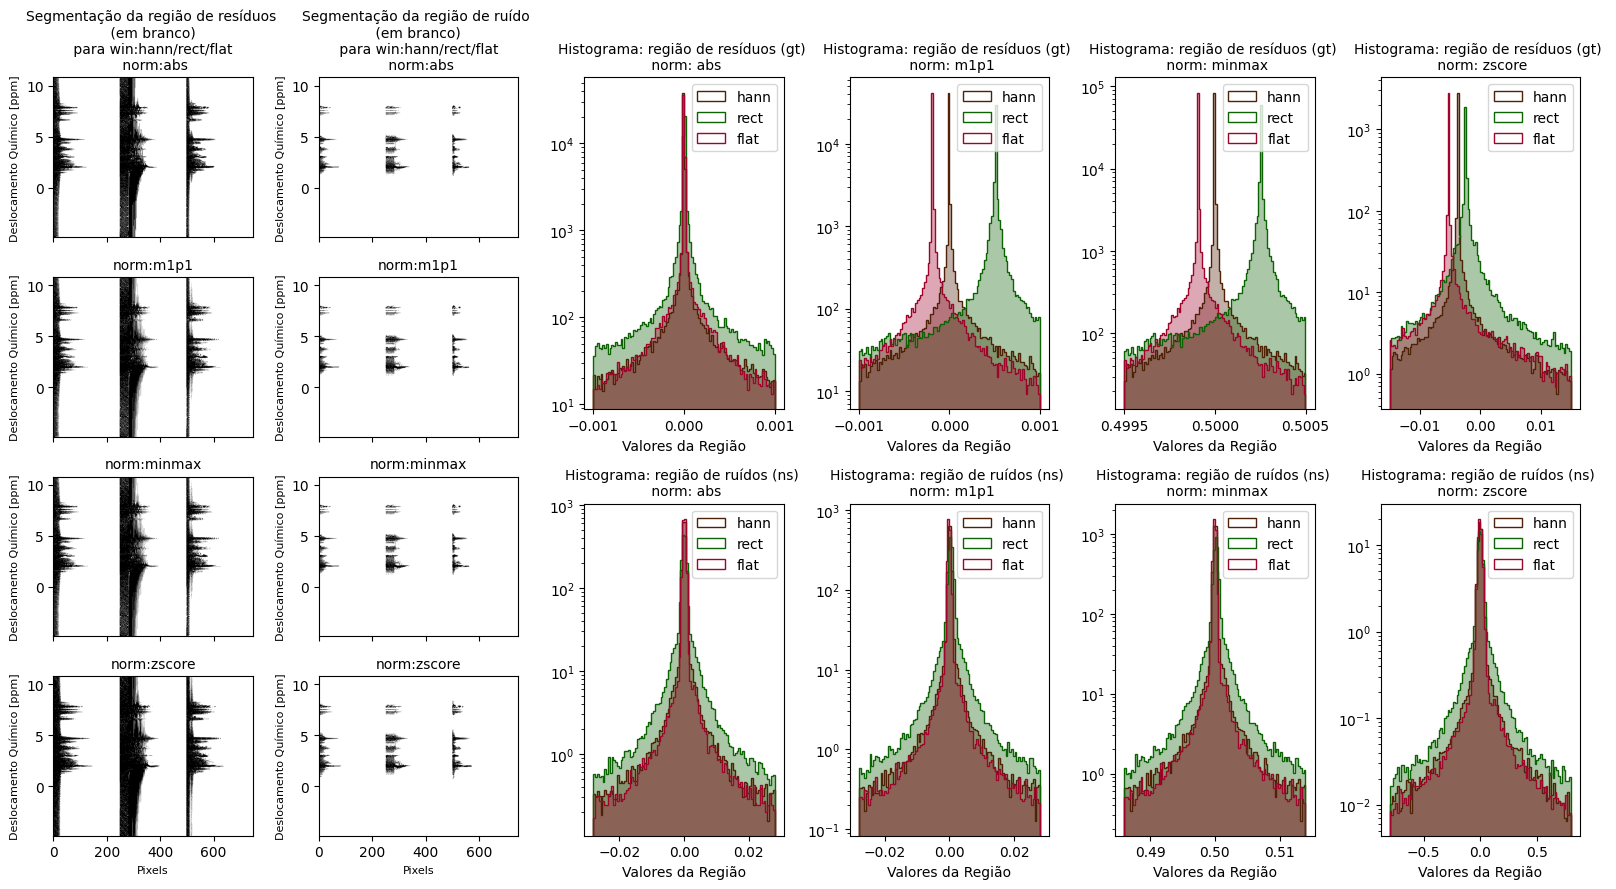

In [36]:
color_list = ['#4f2207','#0c6304','#9e052b']
regions_gt = [0.001,0.001,0.0005,0.015]
regions_ns = [0.028,0.028,0.014,0.8]

fig = plt.figure(figsize=(16, 9))
outer_grid = fig.add_gridspec(2, 6)
ax1 = outer_grid[:, 0].subgridspec(4,1, wspace=0.2, hspace=0.25)
ax1_in = ax1.subplots() 
ax2 = outer_grid[:, 1].subgridspec(4,1, wspace=0.2, hspace=0.25)
ax2_in = ax2.subplots() 
ax3 = outer_grid[0, 2].subgridspec(1,1).subplots()
ax4 = outer_grid[0, 3].subgridspec(1,1).subplots()
ax5 = outer_grid[0, 4].subgridspec(1,1).subplots() 
ax6 = outer_grid[0, 5].subgridspec(1,1).subplots()
ax7 = outer_grid[1, 2].subgridspec(1,1).subplots()
ax8 = outer_grid[1, 3].subgridspec(1,1).subplots()
ax9 = outer_grid[1, 4].subgridspec(1,1).subplots() 
ax10 = outer_grid[1, 5].subgridspec(1,1).subplots()

ax1_in[0].imshow(concat_abs_aux_gt,cmap='gray',aspect='auto',origin='lower',
                         extent=(0, concat_abs_aux_gt.shape[-1],
                                 np.flip(spgram_wn_gt['norm_'+norm_[0]]['window_'+win_name[0]][2])[0],
                                 np.flip(spgram_wn_gt['norm_'+norm_[0]]['window_'+win_name[0]][2])[-1]))
ax1_in[1].imshow(concat_m1p1_aux_gt,cmap='gray',aspect='auto',origin='lower',
                         extent=(0, concat_abs_aux_gt.shape[-1],
                                 np.flip(spgram_wn_gt['norm_'+norm_[0]]['window_'+win_name[0]][2])[0],
                                 np.flip(spgram_wn_gt['norm_'+norm_[0]]['window_'+win_name[0]][2])[-1]))
ax1_in[2].imshow(concat_minmax_aux_gt,cmap='gray',aspect='auto',origin='lower',
                         extent=(0, concat_abs_aux_gt.shape[-1],
                                 np.flip(spgram_wn_gt['norm_'+norm_[0]]['window_'+win_name[0]][2])[0],
                                 np.flip(spgram_wn_gt['norm_'+norm_[0]]['window_'+win_name[0]][2])[-1]))
ax1_in[3].imshow(concat_zscore_aux_gt,cmap='gray',aspect='auto',origin='lower',
                         extent=(0, concat_abs_aux_gt.shape[-1],
                                 np.flip(spgram_wn_gt['norm_'+norm_[0]]['window_'+win_name[0]][2])[0],
                                 np.flip(spgram_wn_gt['norm_'+norm_[0]]['window_'+win_name[0]][2])[-1]))

ax2_in[0].imshow(concat_abs_aux_ns,cmap='gray',aspect='auto',origin='lower',
                         extent=(0, concat_abs_aux_ns.shape[-1],
                                 np.flip(spgram_wn_ns['norm_'+norm_[0]]['window_'+win_name[0]][2])[0],
                                 np.flip(spgram_wn_ns['norm_'+norm_[0]]['window_'+win_name[0]][2])[-1]))
ax2_in[1].imshow(concat_m1p1_aux_ns,cmap='gray',aspect='auto',origin='lower',
                         extent=(0, concat_abs_aux_ns.shape[-1],
                                 np.flip(spgram_wn_ns['norm_'+norm_[0]]['window_'+win_name[0]][2])[0],
                                 np.flip(spgram_wn_ns['norm_'+norm_[0]]['window_'+win_name[0]][2])[-1]))
ax2_in[2].imshow(concat_minmax_aux_ns,cmap='gray',aspect='auto',origin='lower',
                         extent=(0, concat_abs_aux_ns.shape[-1],
                                 np.flip(spgram_wn_ns['norm_'+norm_[0]]['window_'+win_name[0]][2])[0],
                                 np.flip(spgram_wn_ns['norm_'+norm_[0]]['window_'+win_name[0]][2])[-1]))
ax2_in[3].imshow(concat_zscore_aux_ns,cmap='gray',aspect='auto',origin='lower',
                         extent=(0, concat_abs_aux_ns.shape[-1],
                                 np.flip(spgram_wn_ns['norm_'+norm_[0]]['window_'+win_name[0]][2])[0],
                                 np.flip(spgram_wn_ns['norm_'+norm_[0]]['window_'+win_name[0]][2])[-1]))

ax1_in[0].tick_params(labelbottom=False)    
ax1_in[1].tick_params(labelbottom=False)    
ax1_in[2].tick_params(labelbottom=False)    
ax2_in[0].tick_params(labelbottom=False)    
ax2_in[1].tick_params(labelbottom=False)    
ax2_in[2].tick_params(labelbottom=False)    

for i in range(4):
    if i == 0:
        ax1_in[i].set_title('Segmentação da região de resíduos \n (em branco) \n para win:hann/rect/flat \n norm:'+norm_[i],fontsize=10)
        ax2_in[i].set_title('Segmentação da região de ruído \n (em branco) \n para win:hann/rect/flat \n norm:'+norm_[i],fontsize=10)
    else:
        ax1_in[i].set_title('norm:'+norm_[i],fontsize=10)
        ax2_in[i].set_title('norm:'+norm_[i],fontsize=10)
    ax1_in[i].set_ylabel('Deslocamento Químico [ppm]',fontsize=8)
    ax2_in[i].set_ylabel('Deslocamento Químico [ppm]',fontsize=8)
    if i == 3:
        ax1_in[i].set_xlabel('Pixels',fontsize=8)
        ax2_in[i].set_xlabel('Pixels',fontsize=8)

ax_list = [ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10]
for i in range(len(norm_)):
    for j in range(len(window_)):
        if i == 2:
            seg_ = np.mean(np.abs(np.real(spgram_wn_gt['norm_'+norm_[i]]['window_'+win_name[j]][0])-0.5),axis=0) < regions_gt[i]
        else:
            seg_ = np.mean(np.abs(np.real(spgram_wn_gt['norm_'+norm_[i]]['window_'+win_name[j]][0])),axis=0) < regions_gt[i]
        aux = (seg_*np.mean(np.real(spgram_wn_gt['norm_'+norm_[i]]['window_'+win_name[j]][0]),axis=0)).ravel()
        aux = aux[aux != 0]
        im=ax_list[i].hist(aux,100,density = True,histtype='step',color=color_list[j],label=win_name[j])
        im=ax_list[i].hist(aux,100,density = True,alpha=0.35,color=color_list[j])
        if i == 2:
            seg_ = np.mean(np.abs(np.real(spgram_wn_ns['norm_'+norm_[i]]['window_'+win_name[j]][0])-0.5),axis=0) < regions_ns[i]
        else:
            seg_ = np.mean(np.abs(np.real(spgram_wn_ns['norm_'+norm_[i]]['window_'+win_name[j]][0])),axis=0) < regions_ns[i]
        aux = (seg_*np.mean(np.real(spgram_wn_ns['norm_'+norm_[i]]['window_'+win_name[j]][0]),axis=0)).ravel()
        aux = aux[aux != 0]
        im=ax_list[i+4].hist(aux,100,density = True,histtype='step',color=color_list[j],label=win_name[j])
        im=ax_list[i+4].hist(aux,100,density = True,alpha=0.35,color=color_list[j])
        
    ax_list[i+4].legend(loc='upper right')
    ax_list[i+4].set_title('Histograma: região de ruídos (ns) \n norm: '+norm_[i],fontsize=10)
    ax_list[i+4].set_xlabel('Valores da Região',fontsize=10)
    ax_list[i].legend(loc='upper right')
    ax_list[i].set_title('Histograma: região de resíduos (gt) \n norm: '+norm_[i],fontsize=10)
    ax_list[i].set_xlabel('Valores da Região',fontsize=10)
    ax_list[i+4].set_yscale('log')
    ax_list[i].set_yscale('log')


plt.tight_layout()
if test_not_save == False:
    plt.savefig('./relatorio_imagens/imagens_wn/spgram_varying_wn_hist_residuo.png')

### 4.0 Observação

Não se explorou afundo mais detalhes da análise estatística dos espectrogramas, em especial, analisando as características de cada região segmentada. Isso foi feito para o estudo do hop e não se mostrou muito informativo, no entanto, esses dados podem ser encontrados nas variáveis gt_metrics e ns_metrics utilizando as chaves: 'max_sec', 'qntty_percent_regions', 'stats_per_region', 'stats_global' dos dicionários.

In [38]:
gt_metrics.keys()

dict_keys(['fwhm_wn', 'fwhm_wn_real', 'sum_segment', 'zcr_', 'max_sec', 'qntty_percent_regions', 'stats_per_region', 'stats_global'])